# Predicción Precios Argentina - MD 2022

Notebook para la competencias de [Kaggle](https://www.kaggle.com/competitions/fcen-md-2022-prediccion-precio-de-propiedades/leaderboard) de la materia MD de la maestria de DM de la UBA.

Autor: Tomás Delvechio

## Configuración de la notebook

A continuación se definen configuraciones que afectaran el resto del notebook.

In [2]:
# Libs estandar de pythons, utiles en todo el notebook
from datetime import date
import os.path
from shutil import which
import sys

# No tocar
EJECUTA_COLAB = 'google.colab' in sys.modules
ESTA_KAGGLE = not EJECUTA_COLAB \
    and which("kaggle") is not None \
    and os.path.exists(os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json"))
#ENTORNO_DESARROLLO = "Desarrollo"
#ENTORNO_PRUEBA = "Prueba"
#ENTORNO_PRODUCCION = "Produccion"

In [3]:
if EJECUTA_COLAB:
    ! pip install numpy pandas matplotlib scipy scikit-learn nltk seaborn


In [4]:
# Libs de data science
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


# Funciones para texto
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize


[nltk_data] Downloading package punkt to /home/tomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Funciones generales

definición de algunas funciones que se utilizaran de forma general

In [5]:
def comparar_listas(l1, l2):
    """Compara la primer lista contra la segunda y retorna lo que le falta y lo que le sobra"""
    lo_que_le_falta = set(l2) - set(l1)
    lo_que_le_sobra = set(l1) - set(l2)
    return lo_que_le_falta, lo_que_le_sobra

def comparar_barrios(lista_barrios_uno, lista_barrios_dos):
    return comparar_listas(lista_barrios_uno, lista_barrios_dos)


def graficar_histogramas(df, columns, ds_type="entrenamiento"):
    for column in columns:
        ax = df[column].plot.hist()
        ax.set_title(f"Histograma de {column} - {ds_type}")
        ax.set_xlabel(f"Cantidad de {column}")
        plt.show()


def graficar_scatters(df, columns, ds_type="entrenamiento", son_fechas=False):
    #print(df[columns].corr()['rooms']['bedrooms'])
    correlations_df = df[columns].corr()
    for column_in_x in columns:
        for column_in_y in columns[columns.index(column_in_x)+1:]:
            #print(column_in_x, column_in_y)
            #print(np.corrcoef(column_in_x, column_in_y))
            if son_fechas:
                plt.plot_date(df[column_in_x], df[column_in_y])
            else:
                plt.scatter(df[column_in_x], df[column_in_y])
                plt.title(f"Diagrama de dispersión entre {column_in_x} / {column_in_y} - {ds_type}")
                plt.text(-0.1, 0.7, f"r = {round(correlations_df[column_in_x][column_in_y], 3)}", fontsize=10, ha='center', va='center', transform=ax.transAxes)
                plt.xlabel(column_in_x)
                plt.ylabel(column_in_y)
            plt.show()


def graficar_correlograma(df, columns, annot=True):
    sns.heatmap(df[columns].corr(), annot=annot)


## Configuraciones editables

Estas variables pueden ser editadas para cambiar comportamientos del notebook

In [6]:
# Editar para cambiar comportamiento
#ENTORNO = ENTORNO_PRUEBA
ELIMINAR_COLS_CON_NAN_PROPORCION = 0.49 # Proporción mínima de NaNs presentes para eliminar una columna


## Datasets

Se listan todos los datasets a considerar a continuación en un dict

In [7]:
datasets = {

    "input": {

        # Dataset de entrenamiento
        "entrenamiento": {
            "nombre": "properati_ar",
            "archivo": 'ar_properties.csv',
            "archivo_comprimido": "ar_properties.csv.gz",
            "comprimido": "gz",
            "url": "https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz",
        },

        # Dataset de prueba
        "prueba": {
            "nombre": "testing",
            "archivo": "a_predecir.csv",
            "archivo_comprimido": "a_predecir.csv.zip",
            "comprimido": "zip",
            "url": "http://tomasdelvechio.github.io/subjects/dm/a_predecir.csv.zip",
        },

    },

    "output": {

        # Dataset de la fase de Limpieza inicial
        "dataset_limpio": {
            "nombre": "dataset_limpio",
            "archivo": "dataset_limpio.csv",
            "comprimido": False,
            "url": None,
        },

        # Dataset para subir a Kaggle
        "solucion": {
            "nombre": "soluciones",
            "archivo": "solucion.csv",
            "comprimido": False,
            "url": None,
        },

    },

}

### Descarga de los datasets

Controla si los datasets estan o no descargado, en caso de no estarlo, los descarga y descomprime

In [8]:
if EJECUTA_COLAB:
    DOWNLOAD_PATH = '/content'
else:
    DOWNLOAD_PATH = '.data/'
    # tratamos de crear el dir por si es la 1era vez que ejecuta
    ! mkdir -p $DOWNLOAD_PATH

for tipo, ds in datasets["input"].items():
    print(f"Verificando ds para {tipo}: {ds['nombre']}")

    fulllpath = os.path.join(
        DOWNLOAD_PATH, f"{ds['archivo_comprimido']}")
    fulllpath_raw = os.path.join(
        DOWNLOAD_PATH, ds["archivo"])

    if os.path.exists(fulllpath_raw):
        # skip download
        print(f"    Dataset {ds['nombre']} ya descargado anteriormente... No se descarga.")
    else:
        url = ds["url"]
        print(f"Descargando {ds['nombre']} desde {url}")
        ! wget -N -O $fulllpath -q $url
        print(f"DS {ds['nombre']} descargado correctamente")
        if ds["comprimido"] == "gz":
            ! gzip -d -f $fulllpath
        elif ds["comprimido"] == "zip":
            ! unzip -n $fulllpath -d ".data/"
            ! rm $fulllpath

archivo_entrenamiento = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["entrenamiento"]["archivo"])
archivo_prueba = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["prueba"]["archivo"])


Verificando ds para entrenamiento: properati_ar
    Dataset properati_ar ya descargado anteriormente... No se descarga.
Verificando ds para prueba: testing
    Dataset testing ya descargado anteriormente... No se descarga.


Preparamos el archivo de salida

In [9]:
archivo_limpieza_inicial = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["dataset_limpio"]["archivo"])
archivo_salida = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["solucion"]["archivo"])

print(f"Archivo intermedio de limpieza inicial: {archivo_limpieza_inicial}")
print(f"Archivo de soluciones: {archivo_salida}")


Archivo intermedio de limpieza inicial: .data/dataset_limpio.csv
Archivo de soluciones: .data/solucion.csv


### Datos externos

In [11]:
# barrios caba segun el gcba
barrios_caba = [
    "Agronomía",
    "Almagro",
    "Balvanera",
    "Barracas",
    "Belgrano",
    "Boedo",
    "Caballito",
    "Chacarita",
    "Coghlan",
    "Colegiales",
    "Constitución",
    "Flores",
    "Floresta",
    "Boca",
    "Paternal",
    "Liniers",
    "Mataderos",
    "Monte Castro",
    "Monserrat",
    "Nueva Pompeya",
    "Nuñez",
    "Palermo",
    "Parque Avellaneda",
    "Parque Chacabuco",
    "Parque Chas",
    "Parque Patricios",
    "Puerto Madero",
    "Recoleta",
    "Retiro",
    "Saavedra",
    "San Cristobal",
    "San Nicolás",
    "San Telmo",
    "Versalles",
    "Villa Crespo",
    "Villa Devoto",
    "Villa General Mitre",
    "Villa Lugano",
    "Villa Luro",
    "Villa Ortuzar",
    "Villa Pueyrredon",
    "Villa Real",
    "Villa Riachuelo",
    "Villa Santa Rita",
    "Villa Soldati",
    "Villa Urquiza",
    "Villa del Parque",
    "Vélez Sarsfield",
]

In [13]:
columnas_id = ["id", "ad_type", ]
columnas_fecha = ["start_date", "end_date", "created_on", ]
columnas_ubicacion = [
    "lat",
    "lon",
    "l1",
    "l2",
    "l3",
    "l4",
    "l5",
    "l6",
]
columnas_publicacion = [
    "price",
    "currency",
    "price_period",
    "title",
    "description",
    "property_type",
    "operation_type",
]

columnas_de_propiedad = [
    'rooms',
    'bedrooms',
    'bathrooms',
    'surface_total',
    'surface_covered',
]


### Lectura de datos

Se levantan los df de prueba y entrenamiento. No se levantan con el índice `index_col="id"` dado que la [página de properati](https://www.properati.com.ar/data) aclara que podria no ser único.

In [10]:
df_entrenamiento_crudo = pd.read_csv(archivo_entrenamiento)#, index_col="id")
df_prueba_inicial = pd.read_csv(archivo_prueba)#, index_col="id")

#if (ENTORNO == ENTORNO_DESARROLLO):
#    # filtro para pruebas rápidas
#    df_entrenamiento_crudo = df_entrenamiento_crudo.loc[(df_entrenamiento_crudo.l2 == "Córdoba") & (
#        df_entrenamiento_crudo.operation_type == 'Venta') & (df_entrenamiento_crudo.property_type == 'Casa')]
#    df_entrenamiento_crudo.shape

assert df_entrenamiento_crudo.shape[1] == 25, "El ds de entrenamiento no tiene 25 atributos. Revisar."
assert df_prueba_inicial.shape[1] == 28, "El ds de prueba no tiene 28 atributos. Revisar."
assert len(df_entrenamiento_crudo) == 1000000, "El dataset no levantó el millon de registros."


# Análisis y Limpieza inicial

La idea de esta sección es una exploración de los datos para tratar que el dataset de entrenamiento se parezca al dataset a predecir.

## Control de columnas y registros entre datasets

Los tipos de datos de las columnas de entrenamiento:

In [9]:
df_entrenamiento_crudo.dtypes


id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                  object
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
price_period        object
title               object
description         object
property_type       object
operation_type      object
dtype: object

En principio hay preeminencia de columnas no numéricas.

In [10]:
df_entrenamiento_crudo.dtypes.value_counts()


object     16
float64     9
dtype: int64

In [11]:
df_entrenamiento_crudo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1000000 non-null  object 
 1   ad_type          1000000 non-null  object 
 2   start_date       1000000 non-null  object 
 3   end_date         1000000 non-null  object 
 4   created_on       1000000 non-null  object 
 5   lat              894233 non-null   float64
 6   lon              894191 non-null   float64
 7   l1               1000000 non-null  object 
 8   l2               1000000 non-null  object 
 9   l3               965273 non-null   object 
 10  l4               306162 non-null   object 
 11  l5               5530 non-null     object 
 12  l6               0 non-null        float64
 13  rooms            714179 non-null   float64
 14  bedrooms         649933 non-null   float64
 15  bathrooms        765122 non-null   float64
 16  surface_total    47

Vamos a describir a continuación cada columna. El Id no se lista pero es la columna 25. No es el index del dataframe.

| # | Columna | Descripción |
|---|---------|-------------|
| 1 | ad_type   | Tipo de publicación o aviso |
|---|---------|-------------|
| 2 | start_date    | Fecha de alta |
| 3 | end_date  | Fecha de baja |
| 4 | created_on    | Fecha de alta de la primer versión |
|---|---------|-------------|
| 5 | lat   | Latitud |
| 6 | lon   | Longitud |
| 7 | l1    | País |
| 8 | l2    | Provincia |
| 9 | l3    | Ciudad |
| 10 | l4    | Barrio |
| 11 | l5    | ??? |
| 12 | l6    | ??? |
|---|---------|-------------|
| 13 | rooms | Cantidad de ambientes |
| 14 | bedrooms  | Cantidad de dormitorios |
| 15 | bathrooms | Cantidad de baños |
| 16 | surface_total | Superficie en m² |
| 17 | surface_covered   | Superficie cubierta en m² |
| 18 | price | Precio publicado |
| 19 | currency  | Moneda del precio |
| 20 | price_period  | si el precio es diario, semanal, mensual |
| 21 | title | título del anuncio |
| 22 | description   | descripcion del anuncio |
| 23 | property_type | Si es casa, depto, PH... |
| 24 | operation_type    | Si es venta, alquiler... |

In [13]:
def ver_columnas(df, preffix='', suffix=''):
    print(preffix, df.columns, suffix)

ver_columnas(df_entrenamiento_crudo, "Entrenamiento:")
ver_columnas(df_prueba_inicial, "Prueba:")

le_falta_a_entrenamiento, le_sobra_a_entrenamiento = comparar_listas(df_entrenamiento_crudo.columns,
                df_prueba_inicial.columns)

print("Columnas en Pruebas pero NO en entrenamiento: ", le_falta_a_entrenamiento)
print("Columnas en Entrenamiento pero NO en pruebas: ", "No Hay" if len(
    le_sobra_a_entrenamiento) == 0 else le_sobra_a_entrenamiento)


Entrenamiento: Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object') 
Prueba: Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'details',
       'additionals', 'services', 'l4', 'l5', 'l6'],
      dtype='object') 
Columnas en Pruebas pero NO en entrenamiento:  {'services', 'details', 'additionals'}
Columnas en Entrenamiento pero NO en pruebas:  No Hay


¿Cuantos registros tiene cada uno de los datasets?

In [14]:
print(f"Cantidad de registros de Entrenamiento: {len(df_entrenamiento_crudo)}")
print(f"Cantidad de registros de Prueba: {len(df_prueba_inicial)}")


Cantidad de registros de Entrenamiento: 1000000
Cantidad de registros de Prueba: 1087


## Análisis de columnas `price` y `currency`

Se explora la columna objetivo `price`.

..:: Tipo de DF: entrenamiento ::..
Tipo de dato de columna price: float64
Cantidad de NaNs en col price: 41757 (4.1757%)
Cantidad de registros con valor Cero en price: 2900 (0.29%)


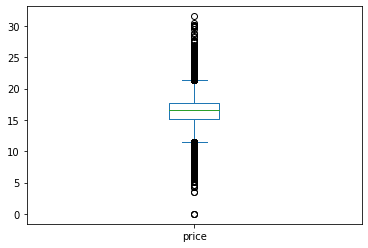

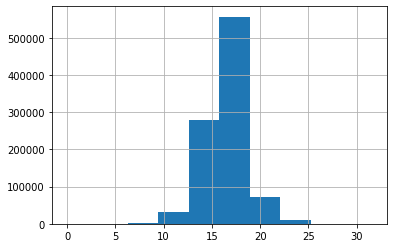

..:: Tipo de DF: Prueba ::..
Tipo de dato de columna price: float64
Cantidad de NaNs en col price: 1087 (100.0%)
Cantidad de registros con valor Cero en price: 0 (0.0%)


In [15]:
def exploracion_precio(df, tipo_df="entrenamiento", plot=True):
    print(f"..:: Tipo de DF: {tipo_df} ::..")
    print(f"Tipo de dato de columna price: {df.price.dtype}")

    nans_en_price_col = df.price.isna().sum()
    print(
        f"Cantidad de NaNs en col price: {nans_en_price_col} ({nans_en_price_col*100/len(df)}%)")

    cantidad_ceros_en_price_col = df.price[df.price == 0].count()
    print(
        f"Cantidad de registros con valor Cero en price: {cantidad_ceros_en_price_col} ({cantidad_ceros_en_price_col*100/len(df)}%)")

    if tipo_df == "entrenamiento" and plot:
        #np.log2(df.price).plot.box()
        #df.price[df.price.notna()].plot.box()
        np.log2(df.price[df.price.notna() & (df.price != 0)]).plot.box()
        plt.show()
        np.log2(df.price[df.price.notna() & (df.price != 0)]).hist()
        plt.show()


exploracion_precio(df_entrenamiento_crudo)
exploracion_precio(df_prueba_inicial, tipo_df="Prueba", plot=False)


Se observa que la columna `price` es de tipo real y que la misma contiene mas de 40 mil registros `NaNs` y casi 3 mil en cero para el dataset de entrenamiento. En el caso de pruebas, obviamente estos valores son todos NaNs.

Se analiza ademas la columna `currency`.

..:: Tipo de DF: entrenamiento ::..
object
44509
2752  currency en nan pero que tienen un precio
Monedas NO peso ni dolar= 3080
Monedas NO peso ni dolar (%)= 0.308
Argentina         2735
Uruguay             14
Estados Unidos       3
Name: l1, dtype: int64


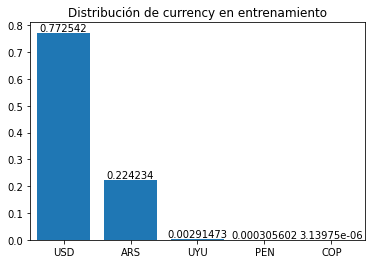

..:: Tipo de DF: Prueba ::..
object
0
0  currency en nan pero que tienen un precio
Monedas NO peso ni dolar= 0
Monedas NO peso ni dolar (%)= 0.0
Series([], Name: l1, dtype: int64)


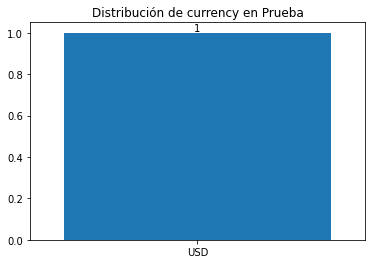

In [16]:
def analisis_columna_currency(df, tipo_df="entrenamiento"):
    print(f"..:: Tipo de DF: {tipo_df} ::..")

    print(df.currency.dtype)
    print(df.currency.isna().sum())
    relative_freq_currency_table = df.currency.value_counts(
        normalize=True, )

    df[df.currency.isna(
    )]['price'].isna().sum() == df.price.isna().sum()
    #for currency_name, currency_rel_freq in df.currency.value_counts(normalize=True, ).items():
    #    df[df.currency == currency_name].value_counts()

    print(df[(df.currency.isna(
    )) & ~(df.price.isna())]["price"].count(), " currency en nan pero que tienen un precio")

    print('Monedas NO peso ni dolar=', df.currency.isin(['UYU', 'PEN', 'COP']).sum())
    print('Monedas NO peso ni dolar (%)=',
        df.currency.isin(['UYU', 'PEN', 'COP']).sum()*100 / len(df))
    
    print(df[(df.currency.isna()) & ~(df.price.isna())]["l1"].value_counts())
    
    ax = relative_freq_currency_table.plot.bar(rot=0, title=f"Distribución de currency en {tipo_df}")
    ax.bar_label(ax.bar(
        relative_freq_currency_table.index, relative_freq_currency_table.values.tolist()))
    plt.show()


analisis_columna_currency(df_entrenamiento_crudo)
analisis_columna_currency(df_prueba_inicial, tipo_df="Prueba")


Del análisis anterior para **entrenamiento**, se puede observar lo siguiente:

 * La mayoria de los registros estan o bien en pesos (~22%) o dolares (~77%).
   * El restante (menos del 0.4%) son otras monedas (cerca de 3 mil registros).
 * Existen ~41 mil registros que no tienen precio
   * Estos mismos coinciden con que no tienen tampoco la `currency`.
 * Existen 2752 que tienen `price` pero sin `currency`.
   * De estos, 2735 son de Argentina, 14 de Uruguay y 3 de USA (se podria imputar `ARS`, `UYU` y `USD` respectivamente).

Para **pruebas**, la cuestión se reduce a que estan presentes el tipo de currency (USD).

## Análisis de columnas de propiedades

A continuación, se analizan los tipos de propiedades presentes en el dataset, es decir, la columna `property_type`.

Venta                750831
Alquiler             207490
Alquiler temporal     41679
Name: operation_type, dtype: int64


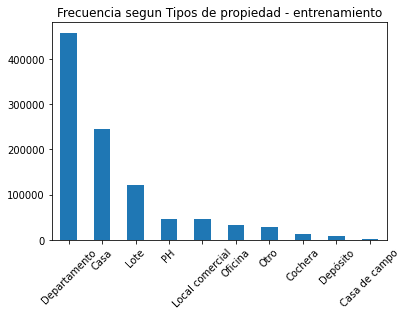

Venta    1087
Name: operation_type, dtype: int64


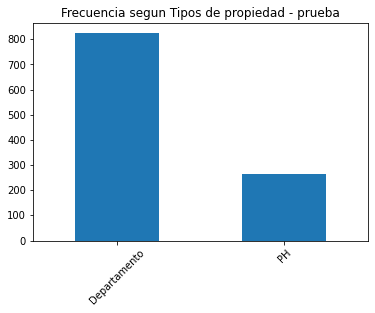

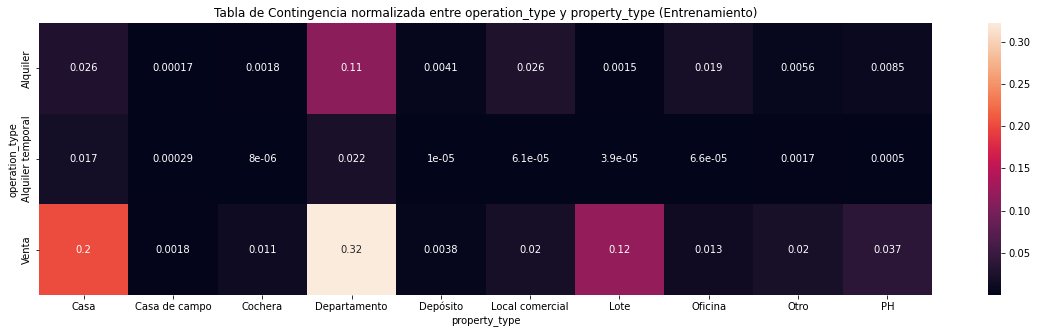

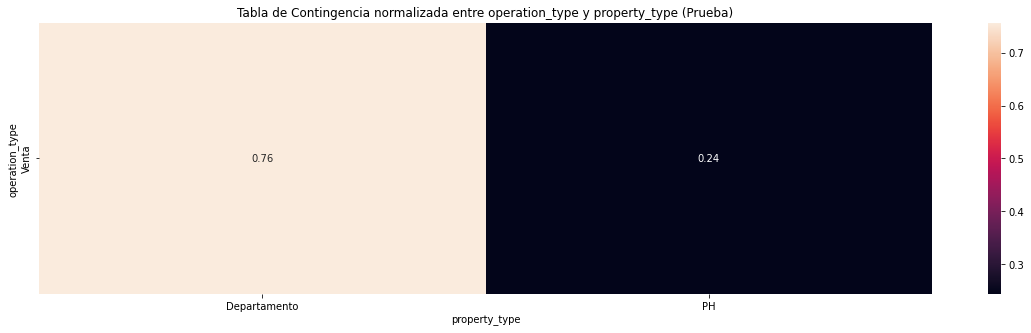

In [17]:
def analisis_operaciones_propiedades(df, tipo_df="entrenamiento"):
    print(df.operation_type.value_counts())
    _ = df.property_type.value_counts().plot.bar(
        rot=45, title=f"Frecuencia segun Tipos de propiedad - {tipo_df}")
    plt.show()

analisis_operaciones_propiedades(df_entrenamiento_crudo)
analisis_operaciones_propiedades(df_prueba_inicial, "prueba")

#df_entrenamiento_crudo.plot.scatter(x="operation_type", y="property_type")
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title(
    'Tabla de Contingencia normalizada entre operation_type y property_type (Entrenamiento)')
sns.heatmap(pd.crosstab(df_entrenamiento_crudo.operation_type,
            df_entrenamiento_crudo.property_type,  normalize=True), annot=True, ax=ax);


fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title(
    'Tabla de Contingencia normalizada entre operation_type y property_type (Prueba)')
sns.heatmap(pd.crosstab(df_prueba_inicial.operation_type,
            df_prueba_inicial.property_type,  normalize=True), annot=True, ax=ax);


Para el caso de entrenamiento:
- A partir de lo anterior, tenemos entonces una preminencia de propiedades de tipo Deptos, casas y lotes.
- Por el lado del tipo de operación, el tipo `Venta` representa prácticamente el 75% de las observaciones.

Para pruebas:
- Se observa que son solo operaciones de venta
- Lo unico presente en el dataset son Deptos y PHs

Analizamos la distribución por Pais:

In [18]:
print(df_entrenamiento_crudo.l1.value_counts())
print(df_prueba_inicial.l1.value_counts())


Argentina         983115
Uruguay            15749
Estados Unidos       892
Brasil               244
Name: l1, dtype: int64
Argentina    1087
Name: l1, dtype: int64


Interesa particularmente ver cuantas publicaciones existen para Argentina, en dolares, en el df de entrenamiento:

In [19]:
print(df_entrenamiento_crudo.currency[df_entrenamiento_crudo.l1 == "Argentina"].value_counts())


USD    724879
ARS    214114
PEN       292
COP         3
Name: currency, dtype: int64


Observamos entonces que existen aprox un ~72% de publicaciones que son de Argentina en dolares.

¿Que hay respecto de las provincias entre entrenamiento y pruebas?

In [20]:
print(df_entrenamiento_crudo.l2.value_counts())
print(df_prueba_inicial.l2.value_counts())


Capital Federal                 265125
Bs.As. G.B.A. Zona Norte        184310
Bs.As. G.B.A. Zona Sur          131431
Santa Fe                         91565
Bs.As. G.B.A. Zona Oeste         76786
Buenos Aires Costa Atlántica     73759
Córdoba                          66274
Buenos Aires Interior            23975
Neuquén                          15487
Mendoza                           9172
Río Negro                         7935
Maldonado                         7784
Entre Ríos                        6750
Tucumán                           6531
Salta                             6056
Montevideo                        5909
Misiones                          4516
San Luis                          2654
Chaco                             1716
La Pampa                          1660
Corrientes                        1573
Chubut                            1529
San Juan                          1390
Colonia                           1213
Canelones                          720
Jujuy                    

## Análisis de fechas

Existen 3 columnas de fechas: start_date, created_on y end_date.

In [21]:
for col in columnas_fecha:
    print(pd.to_datetime(df_entrenamiento_crudo[col], errors='coerce').dtype)


datetime64[ns]
datetime64[ns]
datetime64[ns]


En el caso de la columna end_date, existe una fecha mal ingresada '9999-...' que excede los límites del tipo de dato `datetime64[ns]`.

In [22]:
df_entrenamiento_crudo.end_date.value_counts()


9999-12-31    208960
2021-06-05     70852
2021-04-09     23315
2020-10-03     15205
2020-09-04     14608
               ...  
2021-06-20        83
2020-05-27        72
2020-06-07        66
2020-05-24        29
2020-08-22         1
Name: end_date, Length: 450, dtype: int64

En este caso, se le va a imputar el máximo valor del tipo de dato permitido.

## Generación de dataset limpio

Para organizar el código, acá se definen una serie de reglas de limpieza inicial, Que se guardaran para su uso en las etapas siguientes sin tener que re-ejecutar todo estos pasos nuevamente.

**Definiciones del dataset limpio inicial**

- Se conservan solo filas con currency en dolares.
- Se conservan filas que solo sean de argentina / Capital Federal.
- Se conservan solo las operaciones de venta.
- Se mantienen en el df aquellas propiedades de tipo Departamentos y PH.

Ademas, un conjunto de registros serán descartados en función de los siguientes criterios:

- Se eliminan registros con cero o NaN en `price`.

In [23]:
print("Registros originales", len(df_entrenamiento_crudo))
df_entrenamiento_limpio = df_entrenamiento_crudo[df_entrenamiento_crudo.currency == 'USD']
print("Registros luego de filtrar por publicaciones en dolares", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.l1 == 'Argentina']
print("Registros luego de filtrar por publicaciones de Argentina", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.l2 == 'Capital Federal']
print("Registros luego de filtrar por publicaciones de Capital Federal", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.operation_type == 'Venta']
print("Registros luego de filtrar por publicaciones de tipo Venta", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.property_type.isin(['Departamento', 'PH'])]
print("Registros luego de filtrar por publicaciones de inmuebles Deptos o PHs", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.price.notna()]
print("Registros luego de filtrar por publicaciones con precio en nulo", len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.price != 0]
print("Registros luego de filtrar por publicaciones con precio en cero", len(df_entrenamiento_limpio))


Registros originales 1000000
Registros luego de filtrar por publicaciones en dolares 738157
Registros luego de filtrar por publicaciones de Argentina 724879
Registros luego de filtrar por publicaciones de Capital Federal 191866
Registros luego de filtrar por publicaciones de tipo Venta 179806
Registros luego de filtrar por publicaciones de inmuebles Deptos o PHs 145189
Registros luego de filtrar por publicaciones con precio en nulo 145189
Registros luego de filtrar por publicaciones con precio en cero 145188


Se van a crear campos de tipo datetime, y en el caso de end_date, se imputará el valor máximo del tipo de dato.

In [24]:
pd.Timestamp.max


Timestamp('2262-04-11 23:47:16.854775807')

In [25]:
#pd.Timestamp.max
for columna in columnas_fecha:
    df_entrenamiento_limpio[columna] = pd.to_datetime(
        df_entrenamiento_crudo[columna], errors='coerce').fillna(pd.to_datetime(pd.Timestamp.max))

print(df_entrenamiento_limpio[columnas_fecha].dtypes)
df_entrenamiento_limpio.end_date.value_counts()

start_date    datetime64[ns]
end_date      datetime64[ns]
created_on    datetime64[ns]
dtype: object


2262-04-11 23:47:16.854775807    25888
2021-06-05 00:00:00.000000000    11853
2021-04-09 00:00:00.000000000     2682
2021-06-08 00:00:00.000000000     2628
2020-09-04 00:00:00.000000000     2399
                                 ...  
2020-05-31 00:00:00.000000000        5
2020-06-06 00:00:00.000000000        5
2020-06-21 00:00:00.000000000        3
2020-05-27 00:00:00.000000000        2
2020-05-26 00:00:00.000000000        2
Name: end_date, Length: 447, dtype: int64

Se guarda el dataset para que se parta de este de ahora en adelante.

In [26]:
df_entrenamiento_limpio.to_csv(archivo_limpieza_inicial, index=False)


# Análisis del conjunto de datos

Se analizan ambos datasets para conocerlos y caracterizarlos, ahora que el dataset de entrenamiento se encuentra limpio de registros que no tienen nada que ver con la tarea de predicción a realizar.

In [14]:
df_entrenamiento_inicial = pd.read_csv(
    archivo_limpieza_inicial, parse_dates=columnas_fecha)
df_prueba_inicial = pd.read_csv(
    archivo_prueba, parse_dates=columnas_fecha)
    

In [99]:
#df_prueba_inicial.dtypes
#df_prueba_inicial.shape
#df_prueba_inicial.end_date.value_counts()

2022-04-01    1087
Name: end_date, dtype: int64

## Estudio de dataset de prueba

Se analiza este dataset en mayor profundidad que la sección anterior a fin de determinar cual es la población a predecir. Esto definira algunas estrategias de limpieza de datos.

### Análisis del dataset segun barrios

In [27]:
df_prueba_inicial.l3.value_counts(normalize=True)


Palermo                0.188592
Belgrano               0.101196
Recoleta               0.089236
Caballito              0.068077
Villa Crespo           0.053358
Almagro                0.052438
Barracas               0.035879
Nuñez                  0.033119
Flores                 0.033119
Villa Urquiza          0.031279
Balvanera              0.031279
Colegiales             0.024839
San Telmo              0.022079
Saavedra               0.020239
Boedo                  0.018399
Villa Devoto           0.015639
Monserrat              0.015639
San Nicolás            0.014719
Puerto Madero          0.013799
Floresta               0.012879
Villa del Parque       0.011040
Paternal               0.009200
San Cristobal          0.009200
Villa Ortuzar          0.008280
Parque Patricios       0.008280
Constitución           0.007360
Villa Luro             0.005520
Monte Castro           0.005520
Chacarita              0.005520
Retiro                 0.004600
Villa General Mitre    0.004600
Parque C

¿Cuantos barrios estan presentes? ¿Existen registros que no esten en barrios verdaderos?

In [28]:
barrios_de_menos, barrios_que_no = comparar_barrios(df_prueba_inicial.l3.unique(), barrios_caba)
print("Los siguientes barrios no tiene datos en Properatti **Pruebas**", barrios_de_menos)
print("Los siguientes barrios que SI estan Properatti **Pruebas** no son barrios de CABA en realidad", barrios_que_no)


Los siguientes barrios no tiene datos en Properatti **Pruebas** {'Villa Soldati', 'Villa Riachuelo'}
Los siguientes barrios que SI estan Properatti **Pruebas** no son barrios de CABA en realidad {'2 Ambientes', 'GBA Norte'}


2 cosas hay que hacer con esta información:

- Los barrios que no estén en pruebas, hay que volarlos de entrenamiento (si estuvieran)
- Los barrios que no son, hay que controlar que tengan sentido e imputarles algun valor en testing, o eliminarlos en el caso de training

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

df_prueba_inicial[df_prueba_inicial.l3 == "GBA Norte"]

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
1009,1010,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.510875,-34.544037,Argentina,Capital Federal,GBA Norte,6.0,4.0,3.0,265.0,265.0,NaN,USD,NaN,"Melo Al 4000 - PH en Venta en Vicente López, Vicente López, GBA Norte, Provincia de Buenos Aires de 265 m2 con 4 dormitorios, 3 baños, a .","Vivienda multifamiliar con deposito , galpon, o taller, en inmejorable zona de Villa Martellli . <br>La propiedad se desarrolla sobre un lote irregular de 329 m2, contando en planta baja, al frente, con un taller de 110 m2 con baño .<br>En planta alta , PH de 3/4 amb con lavadero cubierto y terraza con parrilla, y al fondo, casa pequeña de 60 m2 aprox de 3 amb y jardin con parrilla.<br>La zona es muy accesible desde varios puntos, dado que dista solo a 7 cuadras de Colectora mano CABA.<br>Gran oportunidad para proyecto familiar con espacio de trabajo o emprendimiento comercial con vivienda!<br>Se toman propiedades por la zona, en parte de pago, Se escuchan ofertas ! Oportunidad !! Visitala !!<br><br>Nota: La información gráfica y escrita contenida en el presente aviso es meramente a titulo estimativo y no forma parte de ningún tipo de documentación contractual. Las medidas y superficies definitivas surgirán del título de propiedad del inmueble referido. Asimismo los importes de tasas, servicios y expensas indicados están sujetos a verificación. El valor del inmueble indicado en el presente puede ser modificado sin previo aviso.",PH,Venta,"Superficie 265m2, Ambientes 6, Baños 3, Dormitorios 4, Sup. Cubierta 254m2, Antigüedad50 años","Aceptan Mascotas, Terraza","Gas, Luz",NaN,NaN,NaN


In [30]:
df_prueba_inicial[df_prueba_inicial.l3 == "2 Ambientes"]


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
132,133,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.434555,-34.589963,Argentina,Capital Federal,2 Ambientes,2.0,1.0,1.0,51.0,51.0,NaN,USD,NaN,"Avenida Coronel Niceto Vega 5100 - PH en Venta en CABA de 51 m2 con 1 dormitorio, 1 baño, a .","Descripción básica: <br>- PH 2 ambientes de 50m2 con hermoso patio. <br>- Gran luminosidad.<br>- Edificio en muy buen estado.<br><br>Medidas de ambientes:<br>En la planta baja:<br>- Sala de estar 22,68 m2.<br>- Cocina 8,58 m2.<br>En la plata alta:<br>- Anexo 6 m2.<br>- Habitación 24,4 m2.<br>- Baño 3,6 m2.<br> <br>Estado del departamento:<br>- Refaccionado completamente a nuevo. <br> <br>Gastos: <br>-ABL :$400<br>-Expensas : $3.500<br><br>Calidad ambiental:<br>-Realmente muy luminoso ya que cuenta con amplios ventanales, tanto en la planta baja como en la planta alta de la propiedad. <br>- A pesar de estar en una zona muy transitada,por su disposición interna no se escuchan ruidos. <br>- Orientación oeste.<br><br>Calefacción y Refrigeración de Ambientes:<br>- Aire acondicionado frío/calor en la parte de arriba.<br>- Calefactor en la parte de abajo.<br><br>Descripción del Edificio: <br>- Buen estado general.<br><br>Portería:<br>- Limpieza tercerizada. <br><br>Entrega:<br>- Entrega inmediata<br>- Actualmente se encuentra habitado.<br>- La documentación de la propiedad está en condiciones para la compraventa<br><br>Otras aspectos a destacar de la propiedad:<br>-Cocina a gas.<br>- Calefon.<br>- Cocina abierta con barra desayunadora . <br>- Agrandaron la claraboya por lo que genera mucha más iluminación en la planta superior. <br>- La propiedad cuenta con un hermoso patio.<br><br>Accesibilidad:<br>- Colectivos : 34,39,55,108,140,151,166,168.<br>- A 1 cuadra de Avenida Córdoba , a 6 cuadras de Scalabrini Ortiz . <br><br>Descripción del barrio:<br>- La propiedad se encuentra en el barrio de Palermo , que pertenece a la comuna 14 de la ciudad de Buenos Aires ,a pocos minutos de Plaza Italia, al ser un barrio turístico , con muchas opciones gastronómicas y locales comerciales .<br><br>------<br><br>Todas las propiedades publicadas en el perfil de ****** se encuentran a cargo de un profesional matriculado. La intermediación y la conclusión de las operaciones serán llevadas exclusivamente por la firma:<br><br>Carina Beccio<br>Lamac Propiedades<br>Matrícula: CUCICBA 5424",PH,Venta,"Superficie 51m2, Ambientes 2, Baños 1, Dormitorios 1, Sup. Cubierta 51m2, Apto profesionalSí, Antigüedad32 años, Orientación W",Patio,"Gas, Luz",NaN,NaN,NaN


In [31]:
pd.reset_option('display.max_columns')
pd.reset_option('max_colwidth')


De lo anterior, se puede deducir que el inmueble que tiene por error en el barrio el valor "2 Ambientes" es un inmueble de Palermo. El inmueble que esta en GBA Norte, se encuentra en Villa Martelli, no en CABA. Por cercania, se le va a imputar el barrio "Saavedra".

### Estudio de características de la propiedad

Nos referimos acá a las columnas que nos indican propiedades el inmueble en sí.

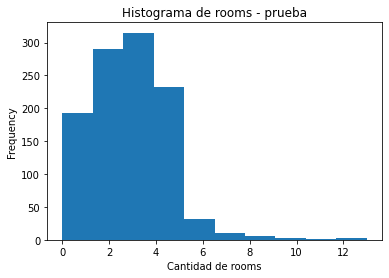

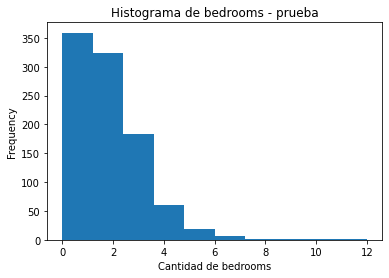

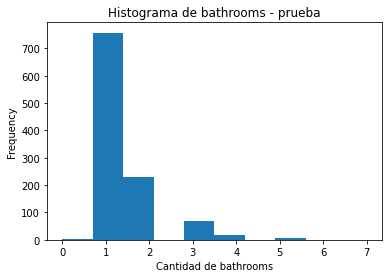

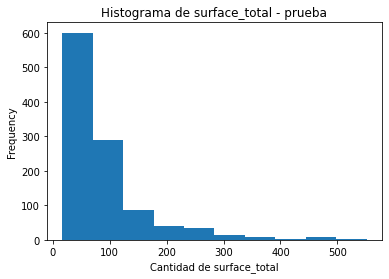

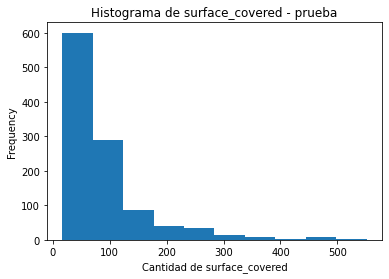

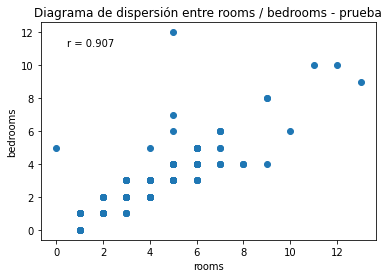

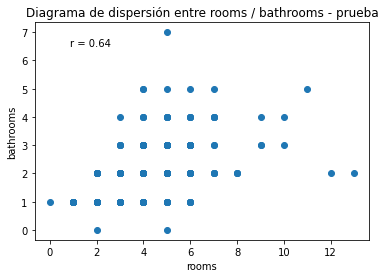

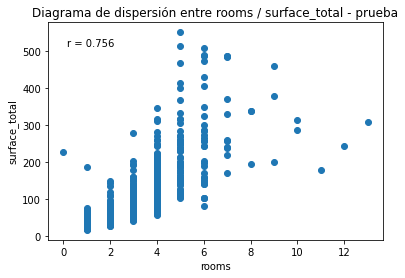

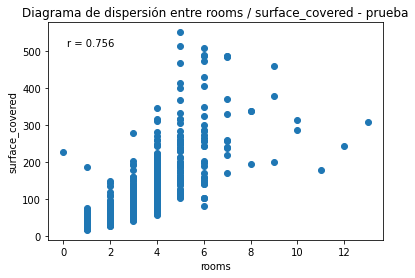

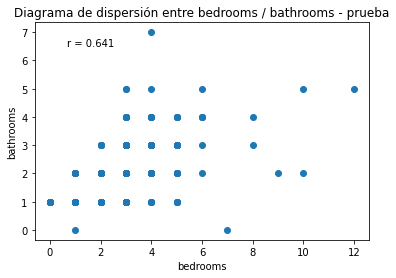

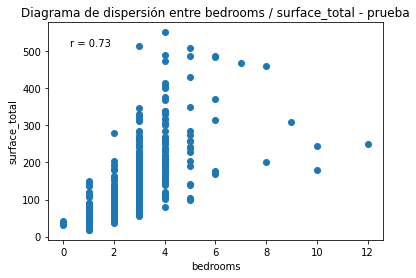

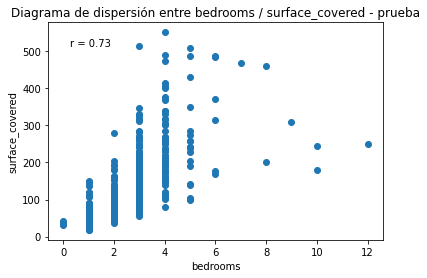

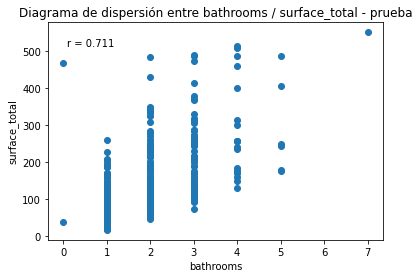

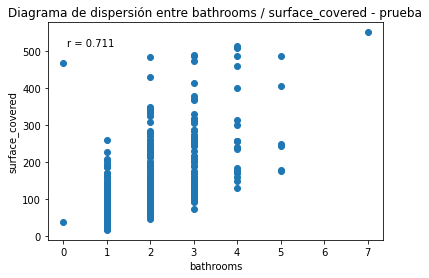

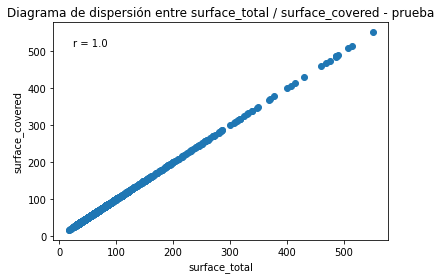

In [32]:
graficar_histogramas(df_prueba_inicial, columnas_de_propiedad, "prueba")
graficar_scatters(df_prueba_inicial, columnas_de_propiedad, "prueba")


## Estudio de dataset de entrenamiento


### Estudio de Columnas de propiedad

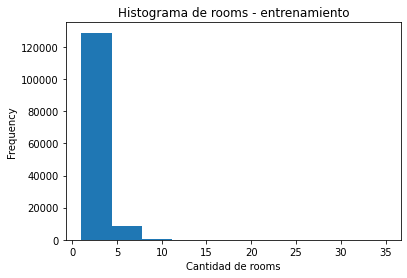

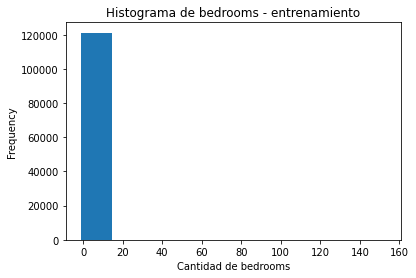

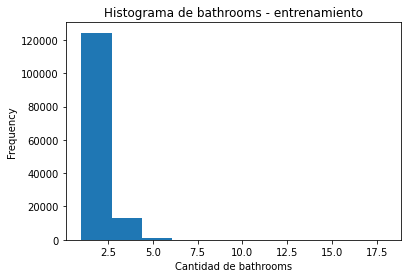

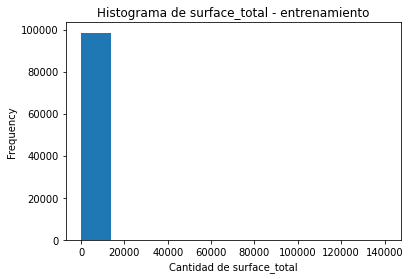

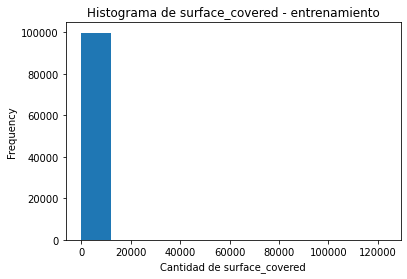

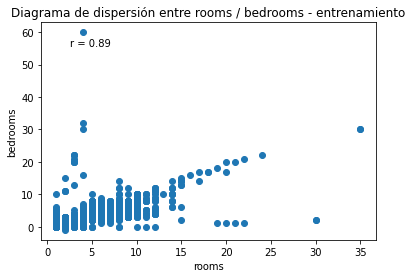

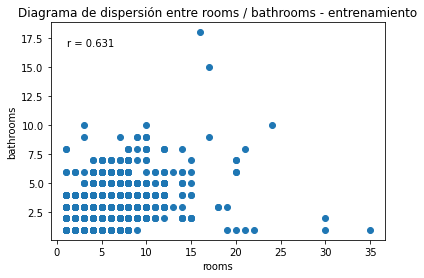

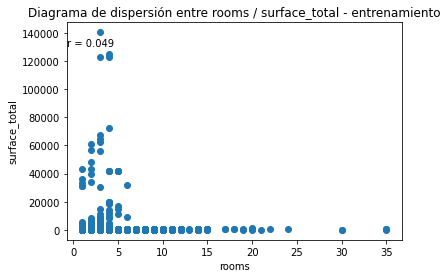

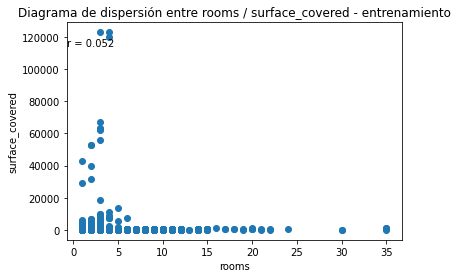

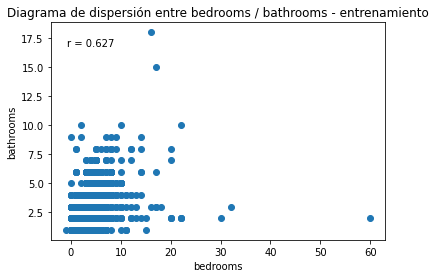

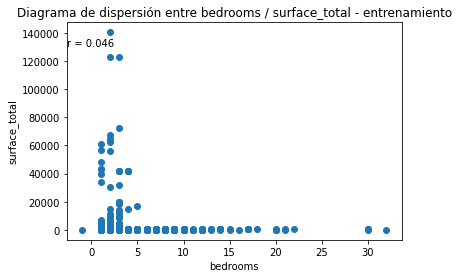

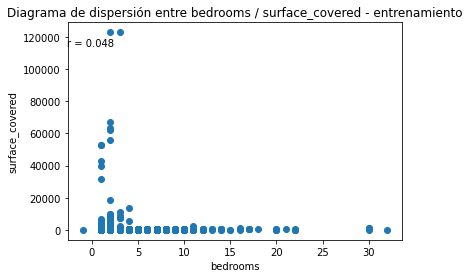

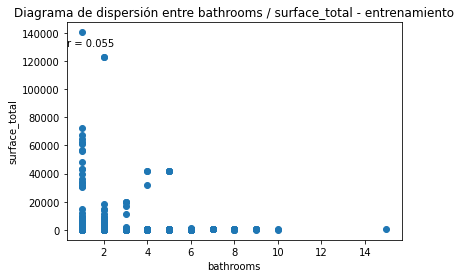

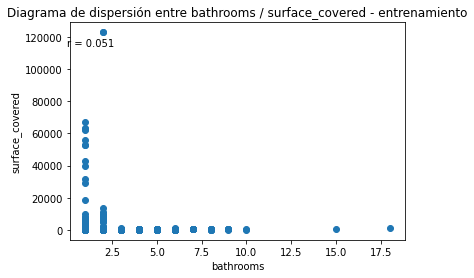

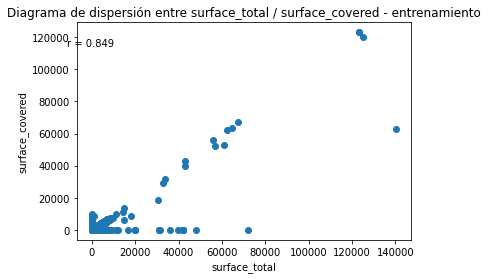

In [34]:
graficar_histogramas(df_entrenamiento_inicial, columnas_de_propiedad)
graficar_scatters(df_entrenamiento_inicial, columnas_de_propiedad)


### Estudio de Barrios

In [35]:
barrios_de_menos, barrios_que_no = comparar_barrios(
    df_entrenamiento_inicial.l3.unique(), barrios_caba)
print("Los siguientes barrios no tiene datos en Properatti **Entrenamiento**", barrios_de_menos)
print("Los siguientes barrios que SI estan Properatti **Entrenamiento** no son barrios de CABA en realidad", barrios_que_no)


Los siguientes barrios no tiene datos en Properatti **Entrenamiento** {'Vélez Sarsfield', 'Villa Pueyrredon', 'Nueva Pompeya'}
Los siguientes barrios que SI estan Properatti **Entrenamiento** no son barrios de CABA en realidad {nan, 'Villa Pueyrredón', 'Abasto', 'Catalinas', 'Pompeya', 'Las Cañitas', 'Congreso', 'Once', 'Barrio Norte', 'Tribunales', 'Parque Centenario', 'Centro / Microcentro', 'Velez Sarsfield'}


In [36]:
barrios_de_menos, barrios_que_no = comparar_barrios(
    df_entrenamiento_inicial.l3.unique(), df_prueba_inicial.l3.unique())
print("Los siguientes barrios no tiene datos en Properatti **Entrenamiento** pero SI estan en Properatti **Prueba**", barrios_de_menos)
print("Los siguientes barrios que SI estan Properatti **Entrenamiento** pero no en Properatti **Prueba**", barrios_que_no)


Los siguientes barrios no tiene datos en Properatti **Entrenamiento** pero SI estan en Properatti **Prueba** {'2 Ambientes', 'Villa Pueyrredon', 'GBA Norte', 'Vélez Sarsfield', 'Nueva Pompeya'}
Los siguientes barrios que SI estan Properatti **Entrenamiento** pero no en Properatti **Prueba** {nan, 'Villa Pueyrredón', 'Abasto', 'Catalinas', 'Pompeya', 'Las Cañitas', 'Villa Riachuelo', 'Villa Soldati', 'Congreso', 'Once', 'Barrio Norte', 'Tribunales', 'Parque Centenario', 'Centro / Microcentro', 'Velez Sarsfield'}


Se van a eliminar de entrenamiento los registros de los barrios que no estan en pruebas. Pero antes es necesario imputar los que si estan pero tienen otros nombres.

In [104]:
# en Pruebas col l3
#   GBA Norte imputar Saavedra
#   2 Ambientes imputar Palermo
df_prueba_inicial.replace({
    'GBA Norte': 'Saavedra',
    '2 Ambientes': 'Palermo',
}, inplace=True)

# conservamos los viejos valores antes de imputarlos
df_entrenamiento_inicial["l3_old"] = df_entrenamiento_inicial.l3

df_entrenamiento_inicial.l3.replace({
    'Pompeya': 'Nueva Pompeya',
    'Villa Pueyrredón': 'Villa Pueyrredon',
    'Velez Sarsfield': 'Vélez Sarsfield',
    'Catalinas': 'Puerto Madero',
    'Abasto': 'Balvanera',
    'Centro / Microcentro': 'San Nicolás',
    'Parque Centenario': 'Caballito',
    'Las Cañitas': 'Palermo',
    'Barrio Norte': 'Recoleta',
    'Tribunales': 'San Nicolás',
    'Congreso': 'Balvanera',
    'Once': 'Balvanera',
    #'': '',
}, inplace=True)


In [111]:
df_entrenamiento_inicial.l3[df_entrenamiento_inicial.l3 == "Barrio Norte"]


Series([], Name: l3, dtype: object)

Entonces, ahora se eliminan publicaciones que tengan su barrio en NaN, en Villa Soldati o Villa Riachuelo

In [106]:
print(df_entrenamiento_inicial.l3.isna().sum())
print((df_entrenamiento_inicial.l3 == "Villa Soldati").sum())
print((df_entrenamiento_inicial.l3 == "Villa Riachuelo").sum())

# Se eliminan de entrenamiento los barrios nan, "Villa Soldati" y "Villa Riachuelo"
print(len(df_entrenamiento_inicial))
df_entrenamiento_inicial = df_entrenamiento_inicial[~df_entrenamiento_inicial.l3.isin(['Villa Soldati', 'Villa Riachuelo'])]
print(len(df_entrenamiento_inicial))
df_entrenamiento_inicial = df_entrenamiento_inicial[df_entrenamiento_inicial.l3.notna()]
print(len(df_entrenamiento_inicial))


565
67
21
145188
145100
144535


En este punto, tenemos un dataset con la información de los barrios de CABA. Para continuar, debemos revisar algunas métricas explorando barrios en entrenamiento y pruebas.

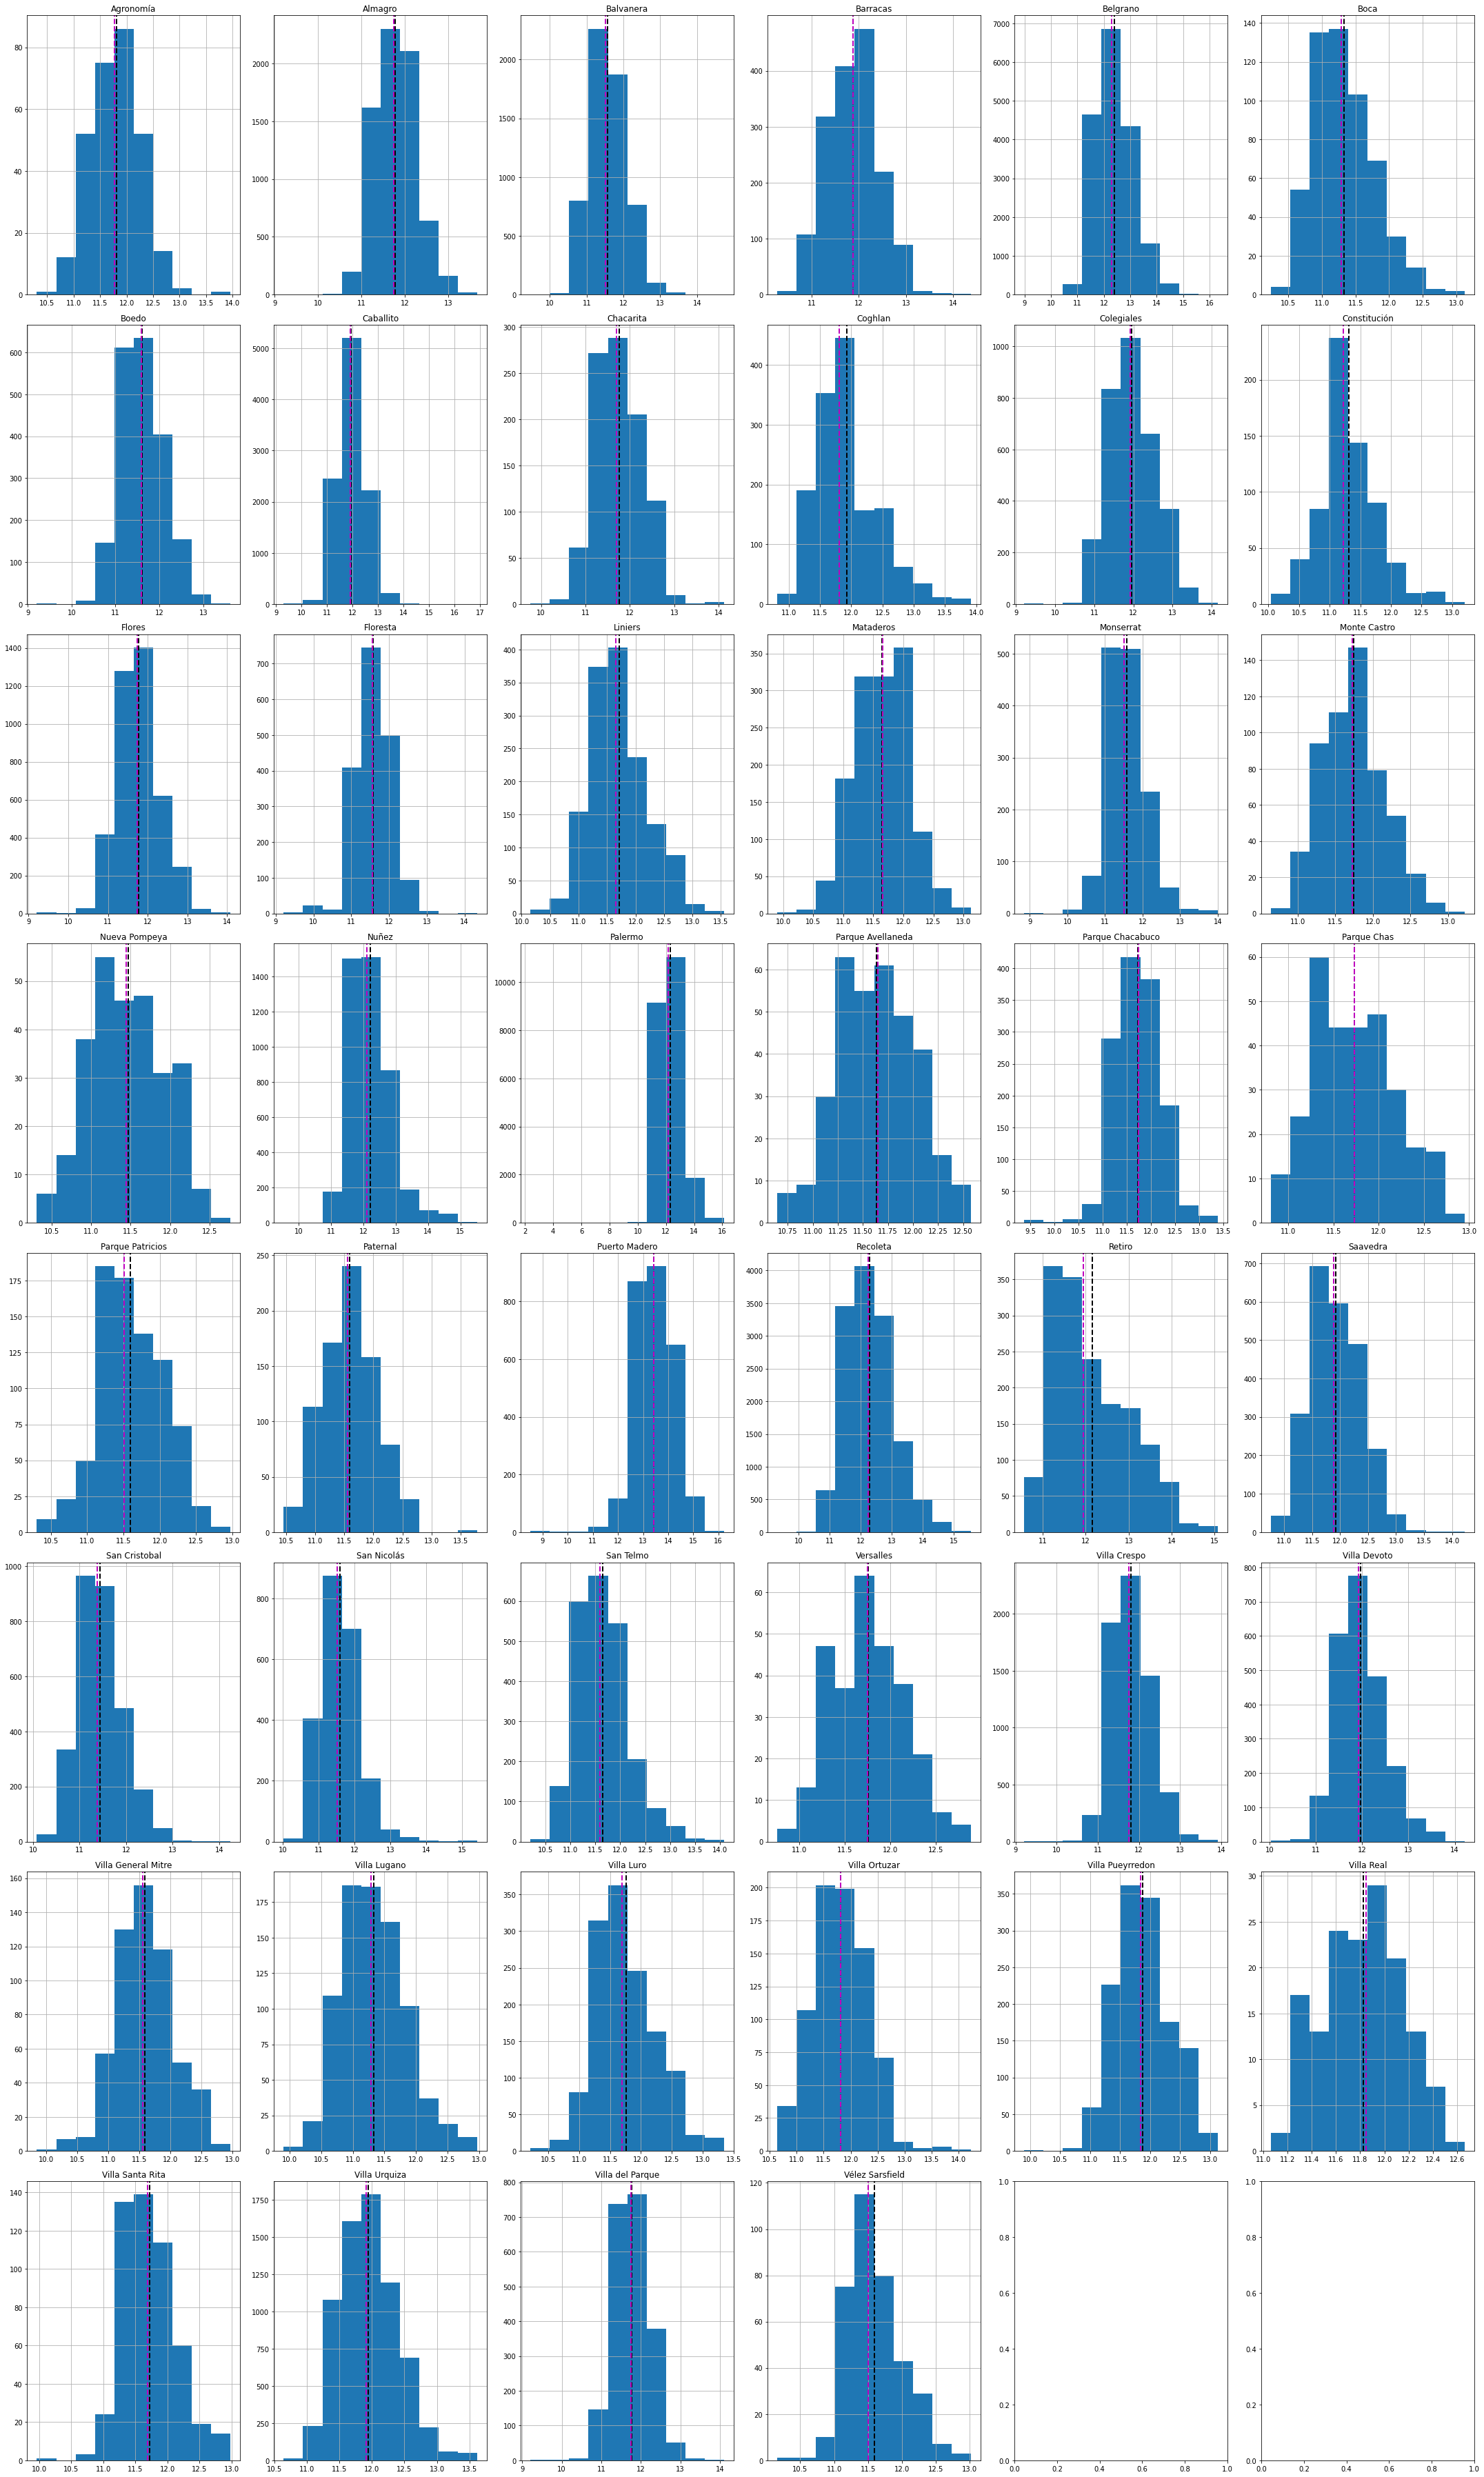

In [39]:
fig, axes = plt.subplots(8, 6, figsize=(30, 50))
axe = axes.ravel()
i=0
for barrio, df_barrio in df_entrenamiento_inicial.groupby('l3'):
    axe[i].set_title(barrio)
    #np.log(df_barrio.price).hist(ax=axe[i])
    np.log(df_barrio.price).hist(ax=axe[i])
    axe[i].axvline(np.log(df_barrio.price).mean(), color='k',
                   linestyle='dashed', linewidth=2)
    axe[i].axvline(np.log(df_barrio.price).median(), color='m',
                   linestyle='dashed', linewidth=2)
    i += 1
fig.tight_layout()
plt.show()


### Estudio de columnas de ubicación

A continuación se estudian los valores relacionados a las columnas de ubicación

In [40]:
print(df_entrenamiento_inicial[columnas_ubicacion].head())
df_entrenamiento_inicial[columnas_ubicacion].tail()


         lat        lon         l1               l2       l3  \
0 -34.597364 -58.372987  Argentina  Capital Federal   Retiro   
1 -34.600004 -58.417191  Argentina  Capital Federal  Almagro   
2 -34.581699 -58.433547  Argentina  Capital Federal  Palermo   
3 -34.595044 -58.442538  Argentina  Capital Federal  Palermo   
4 -34.582549 -58.417350  Argentina  Capital Federal  Palermo   

                  l4  l5  l6  
0                NaN NaN NaN  
1                NaN NaN NaN  
2  Palermo Hollywood NaN NaN  
3                NaN NaN NaN  
4                NaN NaN NaN  


,lat,lon,l1,l2,l3,l4,l5,l6
145183,-34.585810,-58.405548,Argentina,Capital Federal,Recoleta,NaN,NaN,NaN
145184,-34.600052,-58.393015,Argentina,Capital Federal,Recoleta,NaN,NaN,NaN
145185,-34.613926,-58.499472,Argentina,Capital Federal,Monte Castro,NaN,NaN,NaN
145186,-34.573074,-58.419353,Argentina,Capital Federal,Palermo,NaN,NaN,NaN
145187,-34.563411,-58.445656,Argentina,Capital Federal,Belgrano,NaN,NaN,NaN


In [41]:
print("Colname - % de nulls")
df_entrenamiento_inicial[columnas_ubicacion].isna(
).sum() / len(df_entrenamiento_inicial)


Colname - % de nulls


lat    0.057682
lon    0.057682
l1     0.000000
l2     0.000000
l3     0.000000
l4     0.957443
l5     1.000000
l6     1.000000
dtype: float64

l4, l5 y l6 desaparecerán.

Miraremos a continuación la distribución de las columnas númericas.

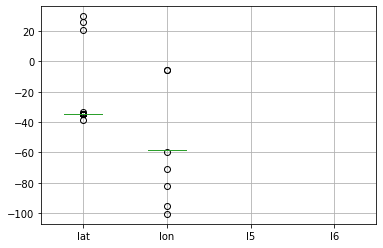

In [42]:
df_entrenamiento_inicial[columnas_ubicacion].boxplot();


### Estudio de columnas de fechas

A continuación se estudian los valores relacionados a las columnas de fechas

In [43]:
df_entrenamiento_inicial[columnas_fecha].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144535 entries, 0 to 145187
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_date  144535 non-null  datetime64[ns]
 1   end_date    144535 non-null  datetime64[ns]
 2   created_on  144535 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 4.4 MB


In [44]:
df_entrenamiento_inicial[columnas_fecha].head()


,start_date,end_date,created_on
0,2020-08-22,2020-09-04,2020-08-22
1,2020-08-22,2020-09-04,2020-08-22
2,2020-08-22,2020-09-04,2020-08-22
3,2020-08-22,2020-09-04,2020-08-22
4,2020-08-22,2020-09-04,2020-08-22


In [45]:
df_entrenamiento_inicial[columnas_fecha].describe(datetime_is_numeric=True)


,start_date,end_date,created_on
count,144535,144535,144535
mean,2020-12-03 12:58:08.937627648,2063-12-02 05:12:28.250808320,2020-12-03 12:58:08.937627648
min,2020-05-24 00:00:00,2020-05-26 00:00:00,2020-05-24 00:00:00
25%,2020-08-31 00:00:00,2020-10-28 00:00:00,2020-08-31 00:00:00
50%,2020-11-20 00:00:00,2021-04-09 00:00:00,2020-11-20 00:00:00
75%,2021-03-24 00:00:00,2021-06-08 00:00:00,2021-03-24 00:00:00
max,2021-06-17 00:00:00,2262-04-11 23:47:16.854775807,2021-06-17 00:00:00


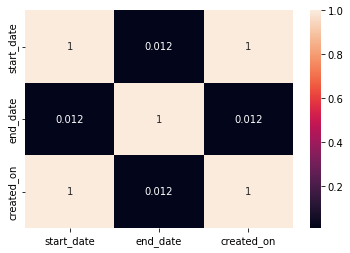

In [46]:
#print(df_entrenamiento_inicial[columnas_fecha].corr(method="pearson"))
#df_entrenamiento_inicial.start_date.corr(df_entrenamiento_inicial.end_date, method="pearson")
#df_entrenamiento_inicial[columnas_fecha].apply(lambda x: x.factorize()[0]).corr()
graficar_correlograma(df_entrenamiento_inicial[columnas_fecha].apply(
    lambda x: x.factorize()[0]), columnas_fecha)


Se observa claramente que `start_date` y `created_on` son la misma columna.

In [47]:
assert (df_entrenamiento_inicial.start_date ==
        df_entrenamiento_inicial.created_on).sum() == len(df_entrenamiento_inicial), \
    "El ds de entrenamiento tiene diferencias entre columnas start_date y created_on"


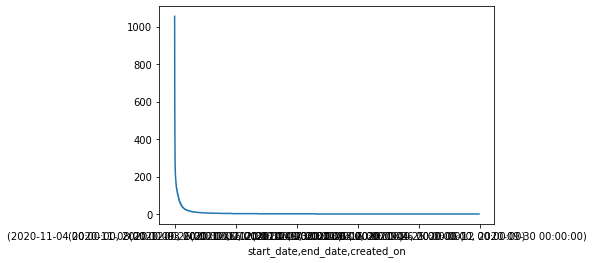

In [48]:
df_entrenamiento_inicial[columnas_fecha].value_counts().plot();
#df_entrenamiento_inicial[columnas_fecha].value_counts()[:5].plot()


Se puede observar que las combinaciones de fechas siguen un patron de "Ley de Potencias".

¿Que pasa con cada columna individual?

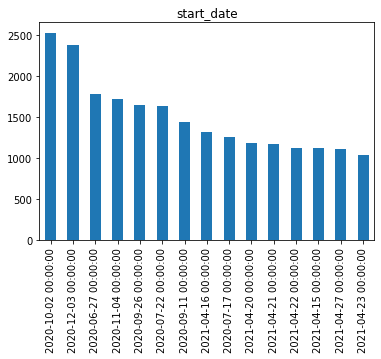

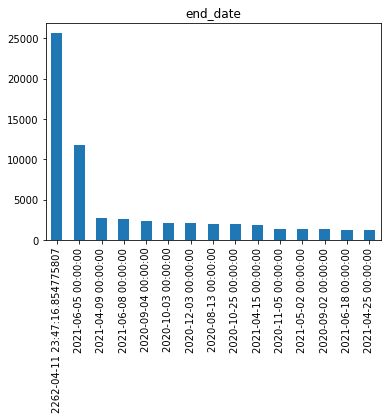

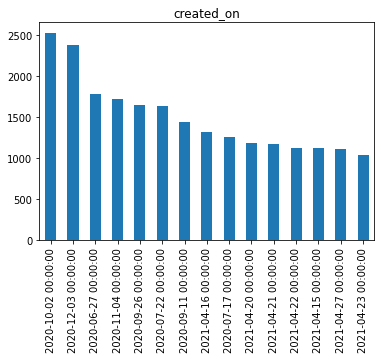

In [49]:
for columna in columnas_fecha:
    df_entrenamiento_inicial[columna].value_counts()[:15].plot(kind='bar')
    plt.title(columna)
    plt.show()


La columna `end_date` se usa bastante mal. El valor con mayor frecuencia es `9999-12-31` (reemplazado por el máximo, pero sigue siendo anomalo). El mismo aparece mas del 20 % de las veces.

### Estudio de columnas de publicación

Las columnas de publicación son aquellas que refieren a información de la propiedad publicada.

In [50]:
df_entrenamiento_inicial[columnas_publicacion].describe(include=object)

,currency,price_period,title,description,property_type,operation_type
count,144535,67507,144535,144535,144535,144535
unique,1,1,77029,111801,2,1
top,USD,Mensual,Departamento - Belgrano,Pozo en Villa Crespo. Monoambientes y Versátil...,Departamento,Venta
freq,144535,67507,1084,98,131151,144535


In [51]:
df_entrenamiento_inicial[columnas_publicacion].describe()


,price
count,1.445350e+05
mean,2.296061e+05
std,3.004743e+05
min,1.100000e+01
25%,1.000000e+05
50%,1.495000e+05
75%,2.402400e+05
max,2.140000e+07


In [52]:
columnas_publicacion_sin_precio = list(columnas_publicacion)
columnas_publicacion_sin_precio.remove('price')


<AxesSubplot:>

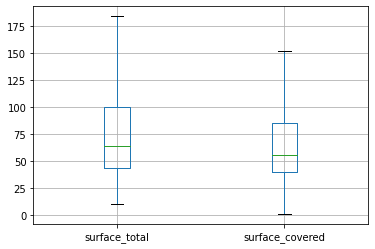

In [53]:
df_entrenamiento_inicial[['surface_total', 'surface_covered']].boxplot(
    showfliers=False)


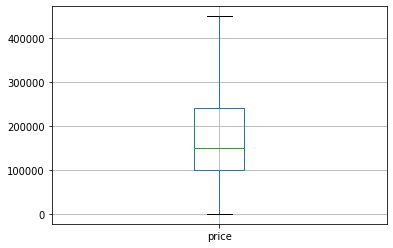

In [54]:
df_entrenamiento_inicial[['price']].boxplot(
    showfliers=False);


En cuanto a los NaNs presentes en estas columnas, se puede observar lo siguiente:

In [38]:
#print("Colname - % de nulls")
#df_entrenamiento_inicial[columnas_publicacion].isna(
#).sum() / len(df_entrenamiento_inicial)

#print("Colname - % de nulls")
prop_nans_por_columna = df_entrenamiento_inicial.isna(
).sum() / len(df_entrenamiento_inicial)
columnas_con_nans_a_descartar = list(
    prop_nans_por_columna[prop_nans_por_columna > ELIMINAR_COLS_CON_NAN_PROPORCION].index)
columnas_con_nans_a_descartar


['l4', 'l5', 'l6', 'price_period']

Se observan varios casos donde la cantidad de NaNs es mas de la mitad de las columnas

In [57]:
#df_entrenamiento_inicial.boxplot(list(df_entrenamiento_inicial.columns))
#df_entrenamiento_inicial.boxplot()


## Varianza de las columnas

se eliminan las columnas cuyos valores son identicos en todos los registros

In [40]:
columnas_con_varianza_cero = []

for column in df_entrenamiento_inicial.columns:
  if (df_entrenamiento_inicial[column] == df_entrenamiento_inicial[column][0]).all():
    columnas_con_varianza_cero.append(column)
    print(f"\nLa col {column} tiene varianza cero")
    print(df_entrenamiento_inicial[column].value_counts())
columnas_con_varianza_cero



La col ad_type tiene varianza cero
Propiedad    145188
Name: ad_type, dtype: int64

La col l1 tiene varianza cero
Argentina    145188
Name: l1, dtype: int64

La col l2 tiene varianza cero
Capital Federal    145188
Name: l2, dtype: int64

La col currency tiene varianza cero
USD    145188
Name: currency, dtype: int64

La col operation_type tiene varianza cero
Venta    145188
Name: operation_type, dtype: int64


['ad_type', 'l1', 'l2', 'currency', 'operation_type']

## Otras columnas a descartar

- Se descarta `created_on` por ser identica a `start_date`

In [41]:
columnas_a_descartar = [
    'created_on',
]

# Tratamiento de los datos

**TODO**
* ~~Determinar método para eliminar columnas con mas de un X % de NaNs.~~
* ~~Pasar cols de fechas a datetimes~~
* ~~Eliminar col created_on pues es igual a start_date~~

In [17]:
print(df_entrenamiento_crudo.shape)
print(df_entrenamiento_inicial.shape)
df_entrenamiento_nuevas_columnas = df_entrenamiento_inicial
df_prueba = df_prueba_inicial.copy()


(145188, 25)
(1000000, 25)


In [22]:
# Generamos sub-datasets
def generar_subdataset(df, column, filter_value):
    filtered_dataset = df[df[column] == filter_value].copy()
    if filtered_dataset.shape[0] > 0:
        # En este caso, algo filtro correctamente
        return filtered_dataset
    else:
        # Algo fallo, devolvió algo vacio
        return None

In [26]:
# Armamos un predictor de palermo
#df_entrenamiento_nuevas_columnas[df_entrenamiento_nuevas_columnas.l3 == "Palermo"]
#df_prueba[df_prueba.l3 == "Palermo"]
#df_entrenamiento_nuevas_columnas.l3.value_counts()

df_entrenamiento_palermo = generar_subdataset(df_entrenamiento_nuevas_columnas, "l3", "Palermo")
df_prueba_palermo = generar_subdataset(df_prueba, "l3", "Palermo")

df_entrenamiento_nuevas_columnas = df_entrenamiento_palermo
df_prueba = df_prueba_palermo


## Creación de nuevas columnas

### Columnas derivadas de fechas

Columnas que se crean a partir de las fechas:

- duracion_publicacion: tiempo que la publicación esta en linea, en cantidad de dias. Resta end_date menos start_date. Si end_date es mayor a fecha de hoy, se queda con fecha de hoy.

In [80]:
#from datetime import date
#pd.to_datetime(date.today())
#max(df_entrenamiento_limpio.end_date)
#min(max(df_entrenamiento_limpio.end_date), pd.to_datetime(date.today()))


163      2020-09-04
164      2020-09-04
165      2020-09-04
166      2020-09-04
167      2020-09-04
            ...    
999931   2022-05-27
999932   2022-05-27
999940   2021-01-10
999977   2020-12-30
999978   2022-05-27
Name: end_date, Length: 145188, dtype: datetime64[ns]

In [91]:
#np.where(df_entrenamiento_inicial.end_date ==
#         pd.Timestamp.max, pd.to_datetime(date.today()), df_entrenamiento_inicial.end_date)
#df_entrenamiento_inicial.end_date[df_entrenamiento_inicial.end_date == pd.Timestamp.max]
#col_end = df_entrenamiento_inicial.end_date.copy()
#col_end.replace({pd.Timestamp.max: pd.to_datetime(date.today())}, inplace=True)
#col_end - df_entrenamiento_inicial.start_date


0         13 days
1         13 days
2         13 days
3         13 days
4         13 days
           ...   
145183   539 days
145184   539 days
145185    37 days
145186    26 days
145187   539 days
Length: 145188, dtype: timedelta64[ns]

In [27]:
def crear_columna_duracion(df, columna_inicio="start_date", columna_fin="end_date"):
    hoy = pd.to_datetime(date.today())
    columna_fin = df[columna_fin].copy()
    columna_fin.replace({pd.Timestamp.max: pd.to_datetime(date.today())}, inplace=True)
    #duracion_publicacion = (columna_fin - df[columna_inicio]).dt.days
    duracion_publicacion = columna_fin - df[columna_inicio]
    return duracion_publicacion.dt.days


df_entrenamiento_nuevas_columnas["duracion_publicacion"] = crear_columna_duracion(df_entrenamiento_nuevas_columnas)
df_prueba["duracion_publicacion"] = crear_columna_duracion(df_prueba)
#df_entrenamiento_palermo["duracion_publicacion"] = crear_columna_duracion(df_entrenamiento_nuevas_columnas)
#df_prueba_palermo["duracion_publicacion"] = crear_columna_duracion(df_prueba)


### Columnas derivadas de barrios

- encoding de barrios
- desvio del m2 promedio de barrio (cubiertos y totales)

In [28]:
BARRIOS_ENCODER=False
if BARRIOS_ENCODER:
    label_encoder = LabelEncoder()
    label_encoder.fit(barrios_caba)
    df_entrenamiento_nuevas_columnas["barrios_encoded"] = label_encoder.transform(df_entrenamiento_nuevas_columnas.l3)
    df_prueba["barrios_encoded"] = label_encoder.transform(df_prueba.l3)


In [29]:
#print(df_entrenamiento_nuevas_columnas.groupby(df_entrenamiento_nuevas_columnas.l3)["surface_total"].mean())
#df_entrenamiento_nuevas_columnas.surface_covered - mediana_surface_covered_por_barrio[df_entrenamiento_nuevas_columnas.l3]
#df_entrenamiento_nuevas_columnas.surface_covered - \
#    mediana_surface_covered_por_barrio[df_entrenamiento_nuevas_columnas.l3]
mediana_surface_covered_por_barrio = df_entrenamiento_nuevas_columnas.groupby(df_entrenamiento_nuevas_columnas.l3)["surface_covered"].mean()
df_entrenamiento_nuevas_columnas["distancia_mediana_m2_cubiertos"] = abs(df_entrenamiento_nuevas_columnas.surface_covered - \
    df_entrenamiento_nuevas_columnas.l3.map(mediana_surface_covered_por_barrio))
df_prueba["distancia_mediana_m2_cubiertos"] = abs(df_prueba.surface_covered - \
    df_prueba.l3.map(mediana_surface_covered_por_barrio))


In [30]:
mediana_surface_total_por_barrio = df_entrenamiento_nuevas_columnas.groupby(
    df_entrenamiento_nuevas_columnas.l3)["surface_total"].mean()
df_entrenamiento_nuevas_columnas["distancia_mediana_m2_totales"] = abs(df_entrenamiento_nuevas_columnas.surface_total - \
    df_entrenamiento_nuevas_columnas.l3.map(mediana_surface_total_por_barrio))
df_prueba["distancia_mediana_m2_totales"] = abs(df_prueba.surface_total - \
    df_prueba.l3.map(mediana_surface_total_por_barrio))


### Columnas derivadas de texto

* Palabras importantes presentes en titulo

In [31]:
# todo a minuscula
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title'].str.lower()
df_prueba['title_tokenized'] = df_prueba['title'].str.lower()

# tokenizacion
regexp = RegexpTokenizer('\w+')
df_entrenamiento_nuevas_columnas["title_tokenized"] = df_entrenamiento_nuevas_columnas["title_tokenized"].apply(regexp.tokenize)
df_prueba["title_tokenized"] = df_prueba["title_tokenized"].apply(regexp.tokenize)

# normalizacion por ahora no

# tratamiento de palabras vacias
stopwords = nltk.corpus.stopwords.words("spanish")
#stopwords.extend(['es', 'osea', 'sólo'])
stopwords.extend(['c'])
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title_tokenized'].apply(lambda texto: [token for token in texto if token not in stopwords])
df_prueba['title_tokenized'] = df_prueba['title_tokenized'].apply(lambda texto: [token for token in texto if token not in stopwords])


In [32]:
stemmer = SnowballStemmer('spanish')
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title_tokenized'].apply(lambda texto: [stemmer.stem(token) for token in texto])
df_prueba['title_tokenized'] = df_prueba['title_tokenized'].apply(lambda texto: [stemmer.stem(token) for token in texto])


In [33]:
df_entrenamiento_nuevas_columnas['title_limpio'] = df_entrenamiento_nuevas_columnas['title_tokenized'].str.join(' ')
df_prueba['title_limpio'] = df_prueba['title_tokenized'].str.join(' ')


In [34]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(
    1, 3), min_df=0.005, max_df=0.9, strip_accents='ascii', max_features=3000)
vectorizer = vectorizer.fit(
    df_entrenamiento_nuevas_columnas['title_limpio'])
vectorized_data_training = vectorizer.transform(df_entrenamiento_nuevas_columnas['title_limpio'])
vectorized_data_testing = vectorizer.transform(df_prueba['title_limpio'])
count_df_training = pd.DataFrame(vectorized_data_training.toarray(), columns=vectorizer.get_feature_names_out())
count_df_testing = pd.DataFrame(vectorized_data_testing.toarray(), columns=vectorizer.get_feature_names_out())


In [35]:
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"] = count_df_training.sum(axis=1) / len(count_df_training.columns)
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"].fillna(0, inplace=True) # Para los títulos que no tienen términos relevantes
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"]


2         0.011538
3         0.023077
4         0.038462
5         0.011538
20        0.023077
            ...   
145134    0.000000
145135    0.000000
145175    0.000000
145176    0.000000
145186    0.000000
Name: cantidad_palabras_importantes_titulo, Length: 21708, dtype: float64

In [36]:
df_prueba["cantidad_palabras_importantes_titulo"] = count_df_testing.sum(axis=1) / len(count_df_testing.columns)
df_prueba["cantidad_palabras_importantes_titulo"].fillna(0, inplace=True) # Para los títulos que no tienen términos relevantes
df_prueba["cantidad_palabras_importantes_titulo"]

2       0.034615
4       0.042308
6       0.057692
7       0.038462
10      0.034615
          ...   
1032    0.000000
1043    0.000000
1057    0.000000
1065    0.000000
1073    0.000000
Name: cantidad_palabras_importantes_titulo, Length: 205, dtype: float64

## Selección de columnas finales


In [42]:
columnas_finales = set(df_entrenamiento_nuevas_columnas.select_dtypes(include=np.number).columns) - \
    set(columnas_con_nans_a_descartar) - \
    set(columnas_con_varianza_cero) - \
    set(columnas_a_descartar)
columnas_finales = list(columnas_finales)
columnas_finales


['price',
 'lat',
 'bathrooms',
 'surface_total',
 'duracion_publicacion',
 'lon',
 'cantidad_palabras_importantes_titulo',
 'distancia_mediana_m2_cubiertos',
 'rooms',
 'distancia_mediana_m2_totales',
 'surface_covered',
 'bedrooms']

In [105]:
df_entrenamiento = df_entrenamiento_nuevas_columnas[columnas_finales]
df_prueba = df_prueba[columnas_finales]


## Outliers

Detectar outliers en base al rango intercuartilico


In [48]:
# Outliers analisis
#df_entrenamiento_inicial[(np.abs(stats.zscore(df_entrenamiento_inicial)) < 3).all(axis=1)]
#np.abs(stats.zscore(df_entrenamiento_inicial)) > 3

def outliers(df, lt, umbral=1.5):
    Q1 = df[lt].quantile(0.25)
    Q3 = df[lt].quantile(0.75)
    IQR = Q3 - Q1
    corte_inferior = Q1 - umbral * IQR
    corte_superior = Q3 + umbral * IQR

    # armo una lista de indices con outliers
    lista = df.index[(df[lt] < corte_inferior) | (df[lt] > corte_superior)]

    return lista

lista_outliers = {}
conjunto_outliers = set([])

# la columna precio no fue incluida
for col in ['rooms', 'bedrooms', 'bathrooms', 'surface_covered', 'surface_total', 'lon', 'lat']:
  lista_outliers[col] = outliers(df_entrenamiento, col)
  conjunto_outliers.update(lista_outliers[col])

print(len(df_entrenamiento))
print(len(lista_outliers))
print(len(conjunto_outliers))

21708
7
2471


In [49]:
df_entrenamiento.describe()


,price,lat,bathrooms,surface_total,duracion_publicacion,lon,cantidad_palabras_importantes_titulo,distancia_mediana_m2_cubiertos,rooms,distancia_mediana_m2_totales,surface_covered,bedrooms
count,2.170800e+04,19843.000000,21156.000000,16699.000000,21708.000000,19843.000000,21708.000000,16910.000000,20888.000000,16699.000000,16910.000000,18090.000000
mean,3.151266e+05,-34.582643,1.555493,115.816755,129.008015,-58.424675,0.004246,54.422141,2.629835,88.301811,87.203312,1.854118
std,4.204506e+05,0.008257,0.865851,994.824692,176.045839,0.011559,0.011721,429.801524,1.355156,990.897821,433.233533,1.048127
min,9.500000e+03,-34.694746,1.000000,14.000000,0.000000,-58.514204,0.000000,0.203312,1.000000,0.183245,1.000000,0.000000
25%,1.250000e+05,-34.588075,1.000000,44.000000,11.000000,-58.433428,0.000000,22.796688,2.000000,35.816755,40.000000,1.000000
50%,1.890000e+05,-34.582098,1.000000,66.000000,43.000000,-58.424137,0.000000,41.203312,2.000000,60.816755,58.000000,2.000000
75%,3.245010e+05,-34.577647,2.000000,105.000000,168.000000,-58.415630,0.000000,54.203312,3.000000,77.816755,91.000000,3.000000
max,9.999999e+06,-34.547531,8.000000,61130.000000,736.000000,-58.350964,0.103846,52942.796688,22.000000,61014.183245,53030.000000,20.000000


## Imputaciones

Varias imputaciones serán realizadas:

- Imputación manual de datos incorrectos
- Simple Imputer para NaNs

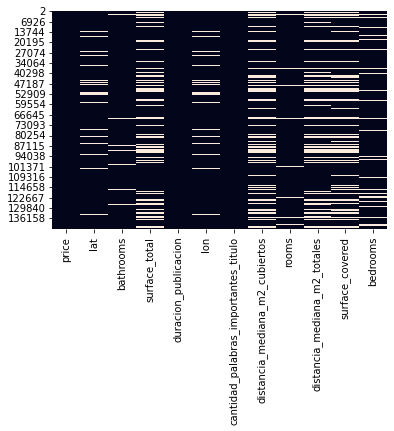

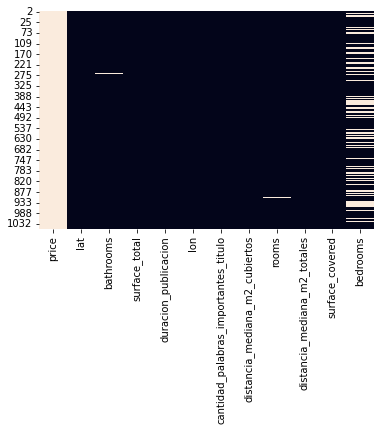

In [106]:
sns.heatmap(df_entrenamiento.isnull(), cbar=False);
plt.show()
sns.heatmap(df_prueba.isnull(), cbar=False);
plt.show()


Se prueba diversos métodos de imputación en referencia a que las columnas tienen muchos datos faltantes.

In [80]:
df_entrenamiento.dtypes


price                                   float64
lat                                     float64
duracion_publicacion                    float64
lon                                     float64
cantidad_palabras_importantes_titulo    float64
rooms                                   float64
bedrooms                                float64
surface_total                           float64
surface_covered                         float64
bathrooms                               float64
distancia_mediana_m2_cubiertos          float64
distancia_mediana_m2_totales            float64
dtype: object

In [245]:
IMPUTAR = False
df_imputado = df_entrenamiento.copy()

if IMPUTAR:

    imp = SimpleImputer(strategy='median')
    # strategy == mean, median, most_frequent, constant

    imp.fit(df_imputado[df_imputado.columns.drop('price')])
    df_imputado[df_imputado.columns.drop('price')] = imp.transform(df_imputado[df_imputado.columns.drop('price')])
    df_prueba[df_imputado.columns.drop('price')] = imp.transform(df_prueba[df_imputado.columns.drop('price')])

    print(df_imputado.isna().sum() / len(df_imputado))
    print(df_prueba.isna().sum() / len(df_prueba))



rooms                                   0.0
distancia_mediana_m2_totales            0.0
bedrooms                                0.0
cantidad_palabras_importantes_titulo    0.0
lat                                     0.0
price                                   0.0
distancia_mediana_m2_cubiertos          0.0
bathrooms                               0.0
surface_total                           0.0
duracion_publicacion                    0.0
surface_covered                         0.0
barrios_encoded                         0.0
lon                                     0.0
dtype: float64
rooms                                   0.0
distancia_mediana_m2_totales            0.0
bedrooms                                0.0
cantidad_palabras_importantes_titulo    0.0
lat                                     0.0
price                                   1.0
distancia_mediana_m2_cubiertos          0.0
bathrooms                               0.0
surface_total                           0.0
duracion_publicac

In [153]:
from sklearn import preprocessing
from sklearn.impute import KNNImputer

def imputacion_knn(df, columnas, df_train=None):
    if df_train is None:
        # escenario de imputacion del propio df de entrenamiento
        df_train = df
    df_train_imputacion = df_train[columnas].copy()
    normalizo_df_train = df_train_imputacion.values
    escala_min_max = preprocessing.MinMaxScaler()
    escala_min_max.fit(normalizo_df_train)
    norm_escala_train = escala_min_max.transform(normalizo_df_train)
    df_norm_train = pd.DataFrame(norm_escala_train, columns=columnas)

    normalizo_df = df[columnas].copy().values
    norm_escala = escala_min_max.transform(normalizo_df)
    df_norm = pd.DataFrame(norm_escala, columns=columnas)

    # Plotea las distribuciones de KNN
    #fig, ax = plt.subplots()
    #sns.kdeplot(df_imputacion.surface_total, label="Original Distribution", ax=ax)
    #df_knn_imputed = df[columnas].copy(deep=True)
    #for n in range(2, 5):
    #    for peso in ["distance", "uniform"]:
    #        imp = KNNImputer(n_neighbors=n, weights=peso)
    #        df_knn_imputed.loc[:, :] = imp.fit_transform(df_imputacion)
    #        sns.kdeplot(
    #            df_knn_imputed.surface_total, label=f"Imputed Dist with k={n}; pesos={peso}", ax=ax)
    #ax.set_xlim(-1000, 1000)
    #plt.legend()

    imp = KNNImputer(n_neighbors=3, weights="distance")
    imputador = imp.fit(df_norm_train)
    #imputador = imputador.fit(df_norm_train)
    df_imputado = imputador.transform(df_norm)
    return pd.DataFrame(df_imputado, columns=columnas, index=df.index)

IMPUTAR_CON_KNN = True
if IMPUTAR_CON_KNN:
    colgroup_uno = ['surface_total', 'surface_covered',
                    'bathrooms', 'distancia_mediana_m2_cubiertos', 
                    'distancia_mediana_m2_totales']
    #df_imputado_train_surfaces = imputacion_knn(df_entrenamiento, colgroup_uno)
    #df_entrenamiento_imputado_surfaces = df_imputado_train_surfaces[df_imputado_train_surfaces.columns]
    df_entrenamiento_imputado_surfaces = imputacion_knn(df_entrenamiento, colgroup_uno)
    df_prueba_imputado_surfaces = imputacion_knn(df_prueba, colgroup_uno, df_entrenamiento)

    colgroup_dos = ['lat', 'lon']
    #df_imputado_train_ubicaciones = imputacion_knn(df_entrenamiento, colgroup_dos)
    #df_entrenamiento_imputado_ubicaciones = df_imputado_train_ubicaciones[df_imputado_train_ubicaciones.columns]
    df_entrenamiento_imputado_ubicaciones = imputacion_knn(df_entrenamiento, colgroup_dos)
    df_prueba_imputado_ubicaciones = imputacion_knn(df_prueba, colgroup_dos, df_entrenamiento)

    colgroup_tres = ['bathrooms', 'rooms', 'bedrooms']
    #df_imputado_train_habitaciones = imputacion_knn(df_entrenamiento, colgroup_tres)
    #df_entrenamiento_imputado_habitaciones = df_imputado_train_habitaciones[df_imputado_train_habitaciones.columns]
    df_entrenamiento_imputado_habitaciones = imputacion_knn(df_entrenamiento, colgroup_tres)
    df_prueba_imputado_habitaciones = imputacion_knn(df_prueba, colgroup_tres, df_entrenamiento)


In [154]:
df_entrenamiento_imputado_surfaces.compare(
    df_entrenamiento[df_entrenamiento_imputado_surfaces.columns])


surface_total        surface_covered        bathrooms        \
                self  other            self  other      self other   
2           0.000344   35.0        0.000547   30.0  0.000000   1.0   
3           0.000605   51.0        0.000849   46.0  0.000000   1.0   
4           0.000638   53.0        0.000981   53.0  0.000000   1.0   
5           0.000262   30.0        0.000547   30.0  0.000000   1.0   
20          0.000540    NaN        0.000830   45.0  0.000000   1.0   
...              ...    ...             ...    ...       ...   ...   
145134      0.001244   90.0        0.001678   90.0  0.142857   2.0   
145135      0.003698  240.0        0.004130  220.0  0.142857   2.0   
145175      0.003452  225.0        0.003847  205.0  0.428571   4.0   
145176      0.002225  150.0        0.002640  141.0  0.285714   3.0   
145186      0.006627  419.0        0.007053  375.0  0.285714   3.0   

       distancia_mediana_m2_cubiertos              \
                                 self       other   
2                            0.001077   57.203312   
3                            0.000774   41.203312   
4                            0.000642   34.203312   
5                            0.001077   57.203312   
20                           0.000793   42.203312   
...                               ...         ...   
145134                       0.000049    2.796688   
145135                       0.002504  132.796688   
145175                       0.002221  117.796688   
145176                       0.001012   53.796688   
145186                       0.005432  287.796688   

       distancia_mediana_m2_totales              
                               self       other  
2                          0.001322   80.816755  
3                          0.001059   64.816755  
4                          0.001027   62.816755  
5                          0.001404   85.816755  
20                         0.001125         NaN  
...                             ...         ...  
145134                     0.000420   25.816755  
145135                     0.002032  124.183245  
145175                     0.001786  109.183245  
145176                     0.000557   34.183245  
145186                     0.004966  303.183245  

[21708 rows x 10 columns]

In [155]:
df_imputado_entrenamiento = pd.concat([df_entrenamiento[['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo']],
                                       df_entrenamiento_imputado_surfaces,
                                       df_entrenamiento_imputado_ubicaciones,
                                       df_entrenamiento_imputado_habitaciones[df_entrenamiento_imputado_habitaciones.columns.drop('bathrooms')]], axis=1)

df_imputado_prueba = pd.concat([df_prueba[['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo']],
                                df_prueba_imputado_surfaces,
                                df_prueba_imputado_ubicaciones,
                                df_prueba_imputado_habitaciones[df_prueba_imputado_habitaciones.columns.drop('bathrooms')]], axis=1)


In [156]:
# Chequeos extras para controlar que todo quedo bien

print(df_entrenamiento.columns)
print(df_entrenamiento.shape)
print(df_imputado_entrenamiento.columns)
print(df_imputado_entrenamiento.shape)

print(df_prueba.columns)
print(df_prueba.shape)
print(df_imputado_prueba.columns)
print(df_imputado_prueba.shape)


Index(['price', 'lat', 'bathrooms', 'surface_total', 'duracion_publicacion',
       'lon', 'cantidad_palabras_importantes_titulo',
       'distancia_mediana_m2_cubiertos', 'rooms',
       'distancia_mediana_m2_totales', 'surface_covered', 'bedrooms'],
      dtype='object')
(21708, 12)
Index(['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo',
       'surface_total', 'surface_covered', 'bathrooms',
       'distancia_mediana_m2_cubiertos', 'distancia_mediana_m2_totales', 'lat',
       'lon', 'rooms', 'bedrooms'],
      dtype='object')
(21708, 12)
Index(['price', 'lat', 'bathrooms', 'surface_total', 'duracion_publicacion',
       'lon', 'cantidad_palabras_importantes_titulo',
       'distancia_mediana_m2_cubiertos', 'rooms',
       'distancia_mediana_m2_totales', 'surface_covered', 'bedrooms'],
      dtype='object')
(205, 12)
Index(['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo',
       'surface_total', 'surface_covered', 'bathrooms',
       '

In [ ]:
DROPNA = False
if DROPNA:
    df_imputado = df_imputado.dropna()


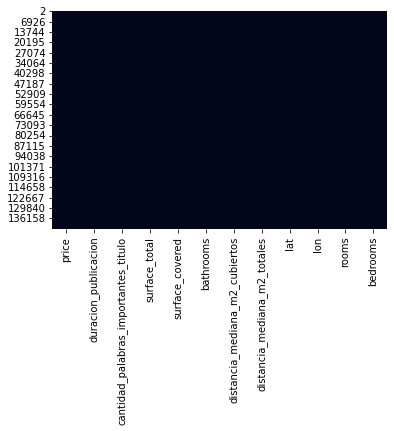

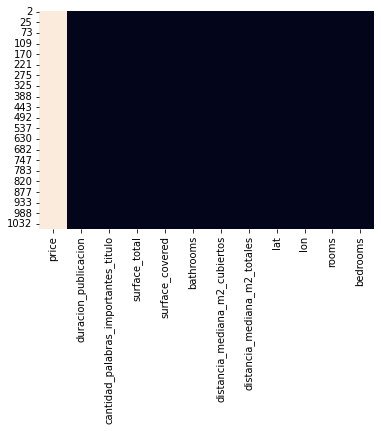

In [159]:
sns.heatmap(df_imputado_entrenamiento.isnull(), cbar=False);
plt.show()
sns.heatmap(df_imputado_prueba.isnull(), cbar=False)
plt.show()


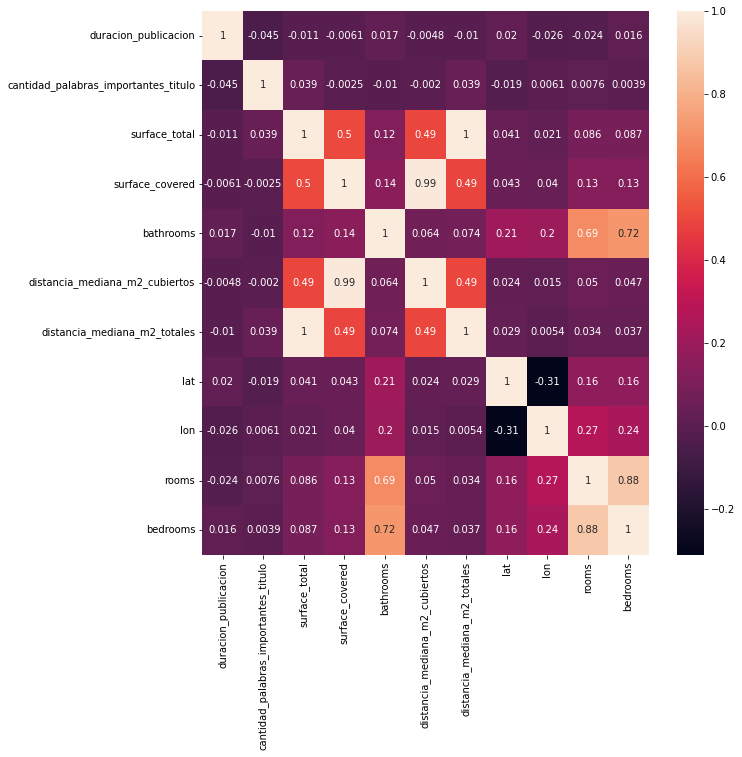

In [161]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_imputado_entrenamiento[df_imputado_entrenamiento.columns.drop(
    'price')].corr(), annot=True, ax=ax);


In [ ]:
# reemplazar esto por un algoritmo
#columnas_con_alta_correlacion = ['bedrooms', 'lat', 'surface_total']
#df_imputado = df_imputado[df_imputado.columns.drop(
#    columnas_con_alta_correlacion)]


In [162]:
df_imputado_prueba.isna().sum()


price                                   205
duracion_publicacion                      0
cantidad_palabras_importantes_titulo      0
surface_total                             0
surface_covered                           0
bathrooms                                 0
distancia_mediana_m2_cubiertos            0
distancia_mediana_m2_totales              0
lat                                       0
lon                                       0
rooms                                     0
bedrooms                                  0
dtype: int64

## Estandarización y Normalización de Datos númericos


In [163]:
df_imputado = df_imputado_entrenamiento
df_prueba = df_imputado_prueba

In [164]:
NORMALIZAR=False

dfe_estandarizado = df_imputado.select_dtypes(
    include=['float64', 'int64', 'uint8'])

if NORMALIZAR:
    # ESTO NO SE SI ANDA
    #df_entrenamiento_inicial.lat.hist(bins=50)

    features = dfe_estandarizado.columns.drop('price')

    # estandarización min-max
    dfe_estandarizado[features] = (dfe_estandarizado[features] -
                        dfe_estandarizado[features].min()) / (dfe_estandarizado[features].max() - dfe_estandarizado[features].min())

    dfe_transformado = pd.DataFrame([])
    dfe_transformado[features] = np.sqrt(dfe_estandarizado[features])
    dfe_transformado["price"] = dfe_estandarizado["price"]

    #dfe_estandarizado = dfe_estandarizado
    #dfe_transformado.lat.hist(bins=50);
else:
    dfe_transformado = dfe_estandarizado


In [165]:
#df_entrenamiento_inicial.lat.describe()
dfe_transformado.head()


,price,duracion_publicacion,cantidad_palabras_importantes_titulo,surface_total,surface_covered,bathrooms,distancia_mediana_m2_cubiertos,distancia_mediana_m2_totales,lat,lon,rooms,bedrooms
2,105000.0,13,0.011538,0.000344,0.000547,0.0,0.001077,0.001322,0.767905,0.494098,0.000000,0.05
3,150000.0,13,0.023077,0.000605,0.000849,0.0,0.000774,0.001059,0.677252,0.439022,0.047619,0.05
4,136500.0,13,0.038462,0.000638,0.000981,0.0,0.000642,0.001027,0.762129,0.593321,0.047619,0.05
5,139000.0,13,0.011538,0.000262,0.000547,0.0,0.001077,0.001404,0.789652,0.546796,0.000000,0.05
20,214400.0,13,0.023077,0.000540,0.000830,0.0,0.000793,0.001125,0.795853,0.460431,0.047619,0.05


## Eliminación de columnas con baja varianza


In [166]:
#df2 = dfe_transformado.select_dtypes(
#    include=['float64', 'int64', 'uint8'])
#
#varianzas_cols = {}
#for c in df2.columns:
#    varianzas_cols[c] = df2[c].var()
#
#varianzas_ordenadas = dict(sorted(varianzas_cols.items(
#), key=lambda item: item[1]), sort_keys=True, indent=4)
#columnas_con_baja_varianza = []
#for col, varianza in varianzas_ordenadas.items():
#    print(col, varianza)
#    if varianza < 1:
#        columnas_con_baja_varianza.append(col)
#
#print(columnas_con_baja_varianza)


lon 6.8049705332785135e-06
lat 1.2824500605989917e-05
l5 nan
l6 nan
surface_covered 0.0001626335898182568
surface_total 0.00022883231518445795
bedrooms 0.0015661735440817297
rooms 0.012103822363539659
bathrooms 0.019509854850466874
price 90284805084.25143
sort_keys True
indent 4
['lon', 'lat', 'surface_covered', 'surface_total', 'bedrooms', 'rooms', 'bathrooms']


In [166]:
columnas_con_baja_varianza = []


# Modelización

A continuación se define la selección de columnas a ser utilizadas

In [167]:
#columnas_a_modelar = set(df_entrenamiento_inicial.columns) - \
#    set(columnas_con_baja_varianza) - \
#    set(columnas_con_nans_a_descartar)
#columnas_a_modelar = list(columnas_a_modelar)
#columnas_a_modelar

print(dfe_transformado.isna().sum() / len(dfe_transformado))
#columnas_seleccionadas = dfe_transformado.columns.drop(['l6', 'l5'])

price                                   0.0
duracion_publicacion                    0.0
cantidad_palabras_importantes_titulo    0.0
surface_total                           0.0
surface_covered                         0.0
bathrooms                               0.0
distancia_mediana_m2_cubiertos          0.0
distancia_mediana_m2_totales            0.0
lat                                     0.0
lon                                     0.0
rooms                                   0.0
bedrooms                                0.0
dtype: float64


## Selección de modelo

In [168]:
#df_entrenamiento_a_modelar = df_entrenamiento_inicial.select_dtypes(include=[
#                                                                    'float64', 'int64'])
df_entrenamiento_a_modelar = dfe_transformado
#df_entrenamiento_a_modelar.fillna(0, inplace=True, downcast="infer")

## Filtro de columnas para el df de pruebas
#df_prueba = df_prueba_inicial[df_entrenamiento_a_modelar.columns].copy(
#)


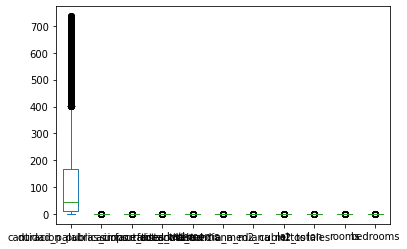

In [169]:
df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop(
    "price")].plot.box();


In [ ]:
if False:
    X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
    y = df_entrenamiento_a_modelar['price']

    for n_estimators in [100, 500, 1000]:
        for max_depth in [3, 7, 11]:

            ## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
            reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

            ## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
            scores = sk.model_selection.cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

            ## Imprimimos scores. Cuando más bajo mejor
            print(f"n_estimators={n_estimators}, max_depth={max_depth} --> {-scores.mean():.3f} +/- {scores.std():.3f}")


In [170]:
X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
y = df_entrenamiento_a_modelar['price']


In [171]:
# version todo por 2 pesos
## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
reg = sk.ensemble.RandomForestRegressor(
    n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)

## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
scores = sk.model_selection.cross_val_score(
    reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

## Imprimimos scores. Cuando más bajo mejor
print(f"{-scores.mean():.3f} +/- {scores.std():.3f}")


182401.310 +/- 35834.517


In [172]:
X_pred = df_prueba[X.columns]


(205, 11)


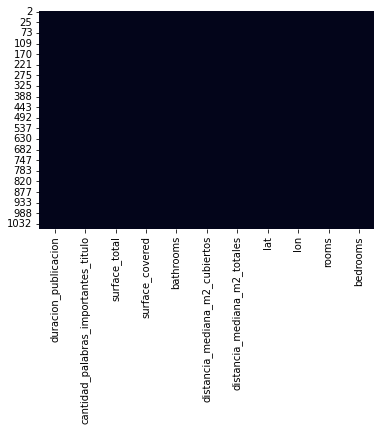

In [173]:
sns.heatmap(X_pred.isnull(), cbar=False)
print(X_pred.shape)


In [174]:
n_estimators = 500
max_depth = 7

# entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
reg.fit(X, y)

# predicción
df_prueba["price"] = reg.predict(X_pred)


In [265]:
# grabo la solución
df_prueba.index.name = 'id'
df_prueba["id"] = df_prueba_inicial.id
df_prueba[["id", "price"]].to_csv(archivo_salida + '_palermo', index=False)


In [266]:
usuario_desea_subir_a_kaggle = (input("Subir a Kaggle? [Default: no]: ", ) or "no") in [
    "s", "S", "si", "Si", "SI", "y", "Y", "yes", "Yes", "YES"]

if ESTA_KAGGLE and usuario_desea_subir_a_kaggle:
    ! kaggle competitions submit -c fcen-md-2022-prediccion-precio-de-propiedades -f $archivo_salida -m "Prueba enviar predicción desde Notebook"

if not usuario_desea_subir_a_kaggle:
    print("El resultado no se subió a Kaggle")

100%|██████████████████████████████████████| 23.8k/23.8k [00:02<00:00, 9.66kB/s]
Successfully submitted to FCEN MD 2022 - Predicción precio de propiedades

: 